# **Introduction**

L'éducation est un enjeu primordial contribuant à la stabilité sociale et au développement économique. Cependant, sur le territoire français, l'éducation est très hétérogène. 
Ainsi, cette étude va permettre de mettre en relief ces disparités aux échelles départementale puis communale, en prenant en compte des indicateurs économiques, culturels et sociaux. 

# **Problématique**

Dans un premier temps, il va s'agir de mettre en évidence les différences d'éducation au sein de la métropole en comparant la part des diplômés dans la population active (personne non scolarisées de 15 ans ou plus) selon les diplômes suivants :
  - CAP/BEPC;
  - BAC;
  - BAC+2;
  - BAC+3 ou BAC+4;
  - BAC+5.

Pour des raisons de représentation géographique, nous allons restreindre l'étude à la France métropolitaine, ainsi que la Corse.

Ensuite, nous allons étudier les effets de plusieurs facteurs en lien avec la réussite au baccalauréat : des facteurs économiques, sociaux et culturels que nous détaillerons plus tard.

Nous aurions voulu mener une étude concernant l'éducation secondaire, et plus précisemment concernant les grandes écoles. En effet, nous voulions mettre en évidence l'inégalité de l'accès aux grandes écoles entre les franciliens et les provinciaux. Cependant, nous ne sommes pas parvenues à trouver des bases microéconomiques des grandes écoles, sûrement au vu de la confidentialité des données. 
De plus, les universités et écoles étant souvent regroupées dans les grandes villes, il était difficile de faire le lien avec les facteurs sociaux et économiques de la ville d'origine.

C'est alors pour ces raisons que nous avons préféré nous concentrer sur l'éducation à un autre niveau : celui du baccalauréat. En effet, les lycées étant présents sur tout le territoire française, nous allons pouvoir mener notre étude.


# **Plan du projet**

### **1. Aperçus des inégalités concernant l'éducation en métropole**
1. Elaboration de fonctions permettant l'importation des données 
2. Importation des données en lien avec l'éducation
3. Importation des données spatiales
4. Statistiques descriptives et visualisation des inégalités en lien avec l'éducation
5. Conclusion

### **2. Importation des données et constitution de la dataframe**
1. Base comparateur des territoires - INSEE
2. Base scolarisation - INSEE
3. Base établissements d'enseignement du premier et second degrés - DATA.EDUCATION.GOUV
4. Base retard en sixième - INSEE
5. Base géographie du cinéma : équipement et fréquentation - DATA.GOUV
6. Base agriculture - INSEE
7. Consolidation des dataframes retenus

### **3. Statistiques descriptives**
1. Visualisation
2. Statistiques univariées
3. Statistiques bivariées
4. Analyse des Composantes Principales
5. Corrélogramme des variables

### **4. Analyse de données**
1. Relation entre le taux de réussite au BAC S et le niveau d'éducation de l'entourage
2. Relation entre le taux de réussite au BAC S et les variables retenues
3. Relation entre le taux de mention au BAC S et les variables retenues

### **5. Prédiction**
1. Prédiction basée sur la régression effectuée en 4.2
2. Prédiction par régression Ridge
3. Prédiction par gradient boost

### **6. Conclusion**

In [3]:
!pip install geopandas
!pip install pygeos 

import pandas as pd
import numpy
import geopandas as gpd

import bs4
import re

import tempfile
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
%matplotlib inline

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

from functools import reduce

import plotly.express as px

     |████████████████████████████████| 972kB 4.9MB/s 
     |████████████████████████████████| 6.5MB 37.2MB/s 
     |████████████████████████████████| 14.8MB 254kB/s 
     |████████████████████████████████| 1.6MB 4.3MB/s 


/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# **1. Aperçus des inégalités concernant l'éducation en métropole**


## **1.1. Elaboration de fonctions permettant l'importation des données**


La première fonction (**csv_zip_to_df**) permet de convertir un **fichier CSV zippé** grâce à son URL en un **dataframe**.

La deuxième fonction (**json_zip_to_df**) permet de convertir un **fichier JSON zippé** grâce à son URL en un **dataframe**.

La troisième fonction (**taux**) permet de **créer taux** correspondant au rapport de 2 autres variables initialement dans la base de données. La variable créée est **arrondie au centième**.

In [4]:
def csv_zip_to_df (url_file,file_name):
  url = urlopen(url_file)
  zipfile = ZipFile(BytesIO(url.read()))
  dataframe = pd.read_csv(zipfile.open(file_name), header = 0,sep=";")
  return dataframe

def json_zip_to_df (url_file,file_name):
  url = urlopen(url_file)
  zipfile = ZipFile(BytesIO(url.read()))
  dataframe = gpd.read_file(zipfile.open(file_name), header = 0,sep=";")
  return dataframe

def taux(new_var,nom_var,denom_var,bdd):
  bdd[new_var] = bdd[nom_var] / bdd[denom_var]
  bdd[new_var] = bdd[new_var].round(decimals=3)
  return bdd[new_var]

## **1.2. Importation des données en lien avec l'éducation**


*Base scolarisation en 2017 - INSEE*

Cette base, issue de l'INSEE (https://www.insee.fr/fr/statistiques/4516086?sommaire=4516089) renvoie des indicateurs sur la **scolarisation par catégories d'âge et la part des diplômés dans la population active** *(personnes non scolarisées de 15 ans ou plus)* **selon le diplôme**, à l'échelle communale. 


Nous allons sélectionner certaines variables afin de créer les suivantes :
- Taux de scolarisation entre 18 et 24 ans (**T17_1824**);
- Taux de scolarisation entre 25 et 29 ans (**T17_2529**);


- Part de la population active n'ayant pas ou peu de diplôme (**T17_NDIP**);
- Part de la population active dont le diplôme le plus élevé est le BEPC ou le brevet (**T17_BEPC**);
- Part de la population active dont le diplôme le plus élevé est un CAP ou BEP (**T17_CAPBEP**);
- Part de la population active dont le diplôme le plus élevé est le BAC (**T17_BAC**);
- Part des diplômés d'un BAC+2 dans la population active (**T17_SUP2**);
- Part des diplômés d'un BAC+3 ou BAC+4 dans la population active (**T17_SUP34**);
- Part des diplômés d'un BAC+5 ou plus dans la population active (**T17_SUP5**).


In [5]:
bdd_scolar = csv_zip_to_df("https://www.insee.fr/fr/statistiques/fichier/4516086/base-ccc-diplomes-formation-2017.zip","base-cc-diplomes-formation-2017.CSV")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



In [6]:
#Création des taux de scolarisation
taux('T17_1824','P17_SCOL1824','P17_POP1824',bdd_scolar)
taux('T17_2529','P17_SCOL2529','P17_POP2529',bdd_scolar)

#Part de diplômés
taux('T17_NDIP','P17_NSCOL15P_DIPLMIN','P17_NSCOL15P',bdd_scolar)
taux('T17_BEPC','P17_NSCOL15P_BEPC','P17_NSCOL15P',bdd_scolar)
taux('T17_CAPBEP','P17_NSCOL15P_CAPBEP','P17_NSCOL15P',bdd_scolar)
taux('T17_BAC','P17_NSCOL15P_BAC','P17_NSCOL15P',bdd_scolar)
taux('T17_SUP2','P17_NSCOL15P_SUP2','P17_NSCOL15P',bdd_scolar)
taux('T17_SUP34','P17_NSCOL15P_SUP34','P17_NSCOL15P',bdd_scolar)
taux('T17_SUP5','P17_NSCOL15P_SUP5','P17_NSCOL15P',bdd_scolar)

0        0.056
1        0.091
2        0.063
3        0.048
4        0.032
         ...  
34991    0.043
34992    0.017
34993    0.034
34994    0.024
34995    0.011
Name: T17_SUP5, Length: 34996, dtype: float64

In [7]:
bdd_scolar['CODGEO']= bdd_scolar['CODGEO'].astype(str).str.zfill(5)
bdd_scolar['DEP']=bdd_scolar['CODGEO'].str[:2]

#Sélection de variables et de communes : on ne garde que celles en métropole
bdd_scolar = bdd_scolar[['CODGEO','DEP','T17_1824','T17_2529','T17_NDIP','T17_BEPC','T17_CAPBEP','T17_BAC','T17_SUP2','T17_SUP34','T17_SUP5']]
bdd_scolar = bdd_scolar[bdd_scolar.DEP !='97']

bdd_scolar.head(5)

CODGEO DEP  T17_1824  T17_2529  ...  T17_BAC  T17_SUP2  T17_SUP34  T17_SUP5
0  01001  01     0.554     0.061  ...    0.170     0.129      0.071     0.056
1  01002  01     0.375     0.077  ...    0.217     0.143      0.114     0.091
2  01004  01     0.387     0.025  ...    0.191     0.122      0.073     0.063
3  01005  01     0.368     0.000  ...    0.179     0.120      0.069     0.048
4  01006  01     0.000     0.000  ...    0.316     0.053      0.053     0.032

[5 rows x 11 columns]

## **1.3. Importation des données spatiales**

Importation des données spatiales **communales**, en enlevant les départements d'outre-mers et en intégrant les arrondissements de Paris

In [8]:
communes = json_zip_to_df("https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12","communes-20190101.json")
communes = communes[communes.insee.str[:3].apply(lambda x: x not in ('971', '972', '973', '974', '975', '976'))]

communes = communes.rename(columns={"insee":"CODGEO"})
communes = communes[['CODGEO','nom','geometry']]

communes.head(5)

CODGEO        nom                                           geometry
7   64026     Anhaux  POLYGON ((-1.33245 43.12096, -1.33054 43.12566...
8   64274  Irouléguy  POLYGON ((-1.30020 43.20058, -1.29818 43.20077...
9   64066    Ascarat  POLYGON ((-1.27637 43.20042, -1.27493 43.20230...
10  64275    Ispoure  POLYGON ((-1.25629 43.19789, -1.25444 43.19776...
11  64166       Çaro  POLYGON ((-1.22116 43.16123, -1.21936 43.16190...

In [9]:
paris = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

paris = paris.rename(columns={"c_arinsee":"CODGEO","l_ar":"nom"})
paris = paris[['CODGEO','nom','geometry']]

paris.head(5)

CODGEO         nom                                           geometry
0   75101    1er Ardt  POLYGON ((2.32801 48.86992, 2.32997 48.86851, ...
1   75102   2ème Ardt  POLYGON ((2.35152 48.86443, 2.35095 48.86341, ...
2   75119  19ème Ardt  POLYGON ((2.38943 48.90122, 2.39014 48.90108, ...
3   75105   5ème Ardt  POLYGON ((2.36443 48.84614, 2.36484 48.84584, ...
4   75108   8ème Ardt  POLYGON ((2.32584 48.86956, 2.32569 48.86954, ...

In [10]:
communes2 = communes[communes.CODGEO!='75']
communes2 = communes2.append(paris)
communes2['CODGEO'] = communes2['CODGEO'].apply(str)

communes2.head(5)

CODGEO        nom                                           geometry
7   64026     Anhaux  POLYGON ((-1.33245 43.12096, -1.33054 43.12566...
8   64274  Irouléguy  POLYGON ((-1.30020 43.20058, -1.29818 43.20077...
9   64066    Ascarat  POLYGON ((-1.27637 43.20042, -1.27493 43.20230...
10  64275    Ispoure  POLYGON ((-1.25629 43.19789, -1.25444 43.19776...
11  64166       Çaro  POLYGON ((-1.22116 43.16123, -1.21936 43.16190...

Importation des données spatiales **départementales**

In [11]:
dpt = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb",header = 0,sep=";")
dpt = dpt.rename(columns={"code":"DEP"})

dpt.head(5)

DEP  ...                                           geometry
0  01  ...  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...
1  02  ...  POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...
2  03  ...  POLYGON ((3.03207 46.79491, 3.03424 46.79080, ...
3  04  ...  POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...
4  05  ...  POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...

[5 rows x 3 columns]

In [12]:
dpt.dtypes

DEP           object
nom           object
geometry    geometry
dtype: object

## **1.4. Statistiques descriptives et visualisation des inégalités en lien avec l'éducation**

### **1.4.1.** Répartition globale des diplômes dans la population active

Afin de pouvoir effectuer une comparaison des différents niveaux de diplômes sur le territoire français, nous allons aggréger tous les taux à l'échelle départementale en effectuant la moyenne des taux par département.

Intéressons nous d'abord à la **proportion d'étudiants de l'enseignement du supérieur** (c'est-à-dire les étudiants **entre 18 et 29  ans**) à l'échelle du département.

In [13]:
#Proportion d'étudiants de l'enseignement du supérieur
bdd_scolar_1829 = bdd_scolar[['T17_1824','T17_2529','DEP']].groupby("DEP").agg({'T17_1824':'mean','T17_2529':'mean'}).reset_index()

melted_bdd_scolar_1829 = pd.melt(bdd_scolar_1829,id_vars=['DEP'],var_name='Part',value_name='Valeur')

fig = px.bar(melted_bdd_scolar_1829, x='DEP', color='Part',
             y='Valeur', range_y=[0,1], 
             title="Proportions d'éudiants de l'enseignement du supérieur",
             labels={'DEP':'Départements'},
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.show()

Ce graphique montre que les taux d'étudiants de l'enseignement supérieur varient entre **0.27 et 0.53**, alors que dans la région parisienne, les taux varient entre **0.51 et 0.91**.

L'évidence que retranscrit ce graphique est que les franciliens semblent faire  bien plus d'études que les provinciaux. Cependant, comme les grandes écoles et les universités sont en grand nombre en région parisienne, nous avons préféré nous référer à d'autres taux, pensant que celui-ci était grandement biaisé.

Nous allons alors étudier la **répartition des diplômés de la population active**.


In [14]:
#Répartition des diplômes dans la population active
bdd_scolar_part = bdd_scolar[['T17_NDIP','T17_BEPC','T17_CAPBEP','T17_BAC','T17_SUP2','T17_SUP34','T17_SUP5','DEP']].groupby("DEP").agg({
    'T17_NDIP':'mean','T17_BEPC':'mean','T17_CAPBEP':'mean','T17_BAC':'mean','T17_SUP2':'mean','T17_SUP34':'mean','T17_SUP5':'mean'}).reset_index()

melted_bdd_scolar_part = pd.melt(bdd_scolar_part,id_vars=['DEP'],var_name='Part',value_name='Valeur')

fig = px.bar(melted_bdd_scolar_part, x='DEP', color='Part',
             y='Valeur', range_y=[0,1], 
             title="Répartition des diplômes dans la population active",
             labels={'DEP':'Départements'},
             color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

La graphique précédent met en évidence les **inégalités des diplômes en fonction des départements**. 

Ce qui interpelle en premier est la **différence significative de la répartition des taux de diplômés à Paris (75) et dans les Hauts-de-Seine (92) en comparaison avec le reste de la France**. En effet, dans ces deux départements, la part de non-diplômés est bien plus faible qu'ailleurs, quand celle des diplômés d'un BAC+5 est bien plus élevée.

Ensuite, on remarque que d'autres départements de la région parisienne (**78, 91 et 94**) ont également une part bien supérieure de diplômés de **BAC+5**. 

De plus, en Province, les départements contenant de grandes métropoles telles que Marseille (**13**), Toulouse (**31**) et Lyon (**69**) ont également une proportion de diplômés de **BAC+5** supérieure au reste de la France.

Intéressons nous maintenant à la part de la population active **sans diplôme**, en violet sur le graphique.
Nous remarquons alors que les départements présentant la part la plus élevée de la population active sans diplôme sont l'Indre (**36**), la Haute-Marne (**52**) et Seine-Saint-Denis (**93**). 

**Les parties suivantes permettent d'étudier les disparités plus précisemment.**


### **1.4.2.** Répartition des diplômés d'un **BAC+5** (au moins) dans la population active 

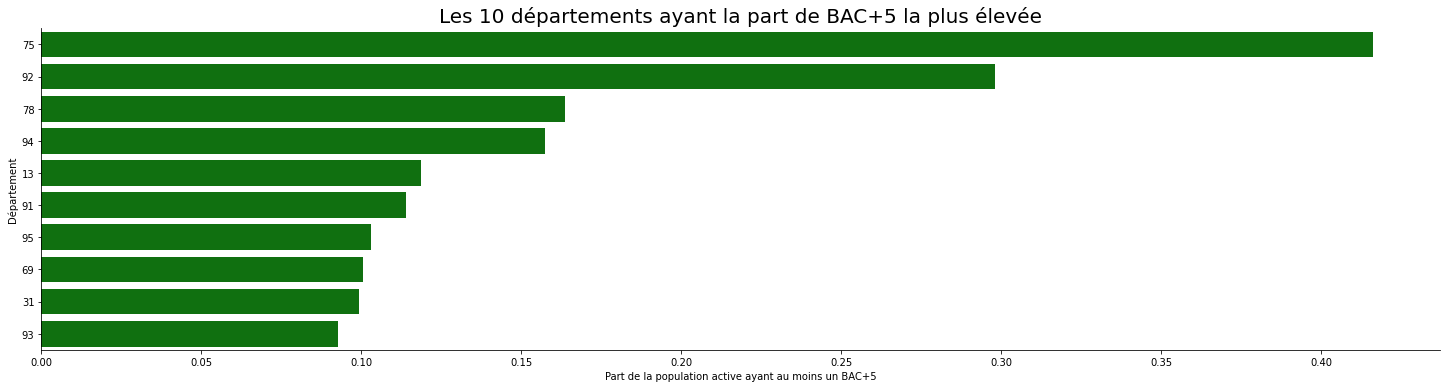

In [15]:
part_sup5 = bdd_scolar_part[['T17_SUP5','DEP']]

#Barplot du top 10 : les 10 départements ayant la part de BAC+5 la plus élevée
top_sup5 = part_sup5.sort_values('T17_SUP5',ascending=False).head(10)

graph_SUP5 = sns.catplot(x='T17_SUP5', y='DEP', data=top_sup5, kind = 'bar', height = 5, aspect = 4, color = "green")
graph_SUP5.set_axis_labels('Part de la population active ayant au moins un BAC+5', 'Département')
plt.title('Les 10 départements ayant la part de BAC+5 la plus élevée',size = 20)
plt.show()

Le barplot met en évidence les 10 départements dans lesquels la **part de la population active ayant un BAC+5 est la plus élevée**. On retrouve ainsi tous les départements composant la région parisienne (dans l'ordre : **75, 92, 78, 94, 91, 95, 93**), ainsi que les départements dans lesquels se trouvent les plus grandes villes de France (**13, 69, 31**).

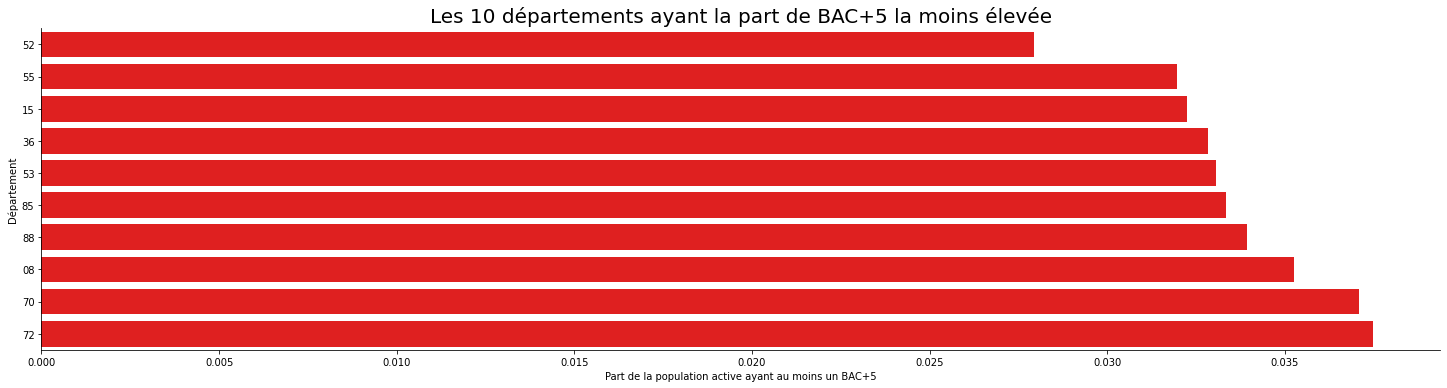

In [16]:
#Barplot du bottom 10 : les 10 départements ayant la part de BAC+5 la moins élevée
bottom_sup5 = part_sup5.sort_values('T17_SUP5',ascending=True).head(10)

graph_SUP5 = sns.catplot(x='T17_SUP5', y='DEP', data=bottom_sup5, kind = 'bar', height = 5, aspect = 4, color = "red")
graph_SUP5.set_axis_labels('Part de la population active ayant au moins un BAC+5', 'Département')
plt.title('Les 10 départements ayant la part de BAC+5 la moins élevée',size = 20)
plt.show()

Le barplot met en évidence les 10 départements dans lesquels la **part de la population active ayant un BAC+5 est la moins élevée**. Tous ces départements ont une grande caractéristique en commun : ils sont très peu touristiques et très ruraux. 

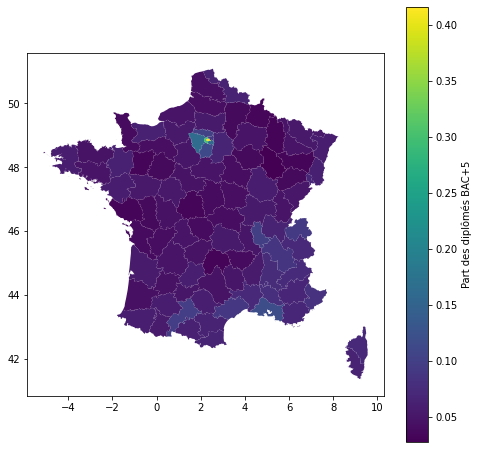

In [17]:
#Carte
dpt.merge(part_sup5, how='left').plot(column = 'T17_SUP5', legend=True, legend_kwds={'label':'Part des diplômés BAC+5'},figsize=(8, 8))

La carte permet alors de visualiser les informations mises en avant grâce aux barplots.

### **1.4.3.** Répartition des diplômés de l'enseignement supérieur dans la population active (population active ayant **au moins un BAC+2**)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



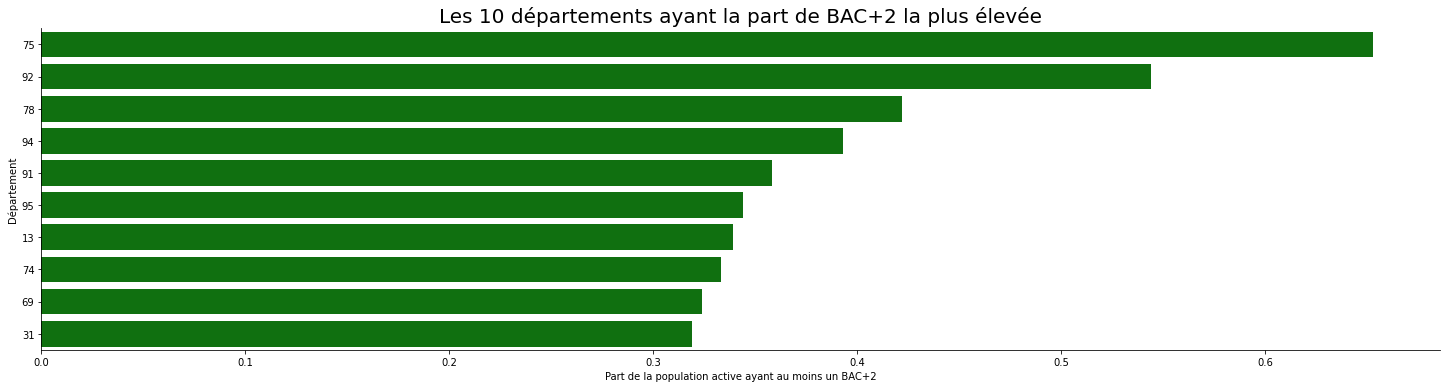

In [18]:
#T17_SUP2 nous donne seulement la part de la population ayant un BAC+2, mais nous pensons plus significatif d'étudier la population 
#ayant AU MOINS un BAC+2.

part_sup2 = bdd_scolar_part[['T17_SUP2','T17_SUP34','T17_SUP5','DEP']]
part_sup2['T17_SUP2_P']= part_sup2['T17_SUP2'] + part_sup2['T17_SUP34'] + part_sup2['T17_SUP5']
part_sup2['T17_SUP2_P']=part_sup2['T17_SUP2_P'].round(decimals=3)

#Barplot du top 10 : les 10 départements ayant la part de BAC+2 la plus élevée
top_sup2 = part_sup2.sort_values('T17_SUP2_P',ascending=False).head(10)

graph_SUP2 = sns.catplot(x='T17_SUP2_P', y='DEP', data=top_sup2, kind = 'bar', height = 5, aspect = 4, color = "green")
graph_SUP2.set_axis_labels('Part de la population active ayant au moins un BAC+2', 'Département')
plt.title('Les 10 départements ayant la part de BAC+2 la plus élevée',size = 20)
plt.show()

Le barplot met en évidence les 10 départements dans lesquels la **part de la population active ayant au moins un BAC+2 est la plus élevée**. Sans grande surprise, tous les départements de la région parisienne sont encore une fois dans le top 10.

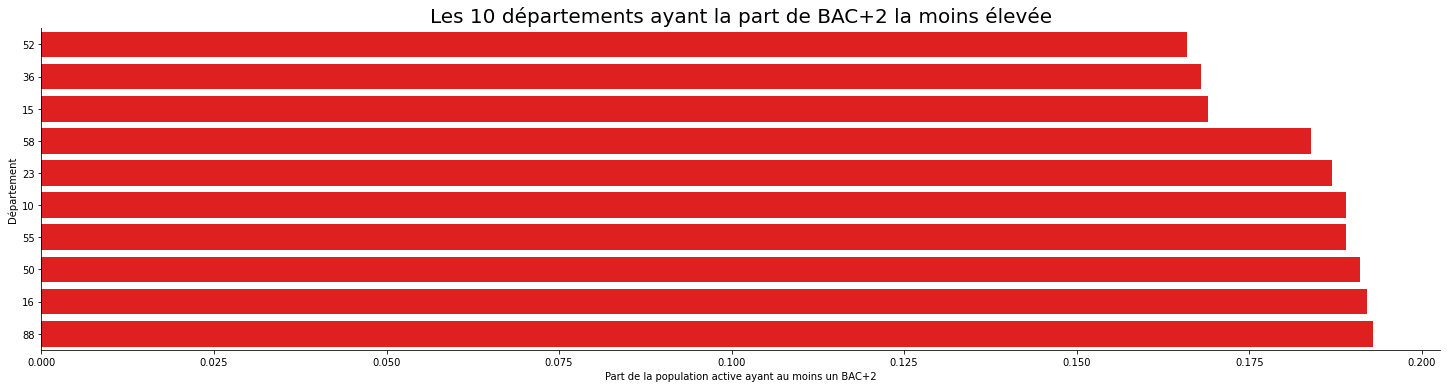

In [19]:
#Barplot du bottom 10 : les 10 départements ayant la part de BAC+2 la moins élevée
bottom_sup2 = part_sup2.sort_values('T17_SUP2_P',ascending=True).head(10)

graph_SUP2 = sns.catplot(x='T17_SUP2_P', y='DEP', data=bottom_sup2, kind = 'bar', height = 5, aspect = 4, color = "red")
graph_SUP2.set_axis_labels('Part de la population active ayant au moins un BAC+2', 'Département')
plt.title('Les 10 départements ayant la part de BAC+2 la moins élevée',size = 20)
plt.show()

Le barplot met en évidence les 10 départements dans lesquels la **part de la population active ayant au moins un BAC+2 est la moins élevée**. Encore une fois, on retrouve à peu près les mêmes départements, tous à tendance majoritairement rurale.

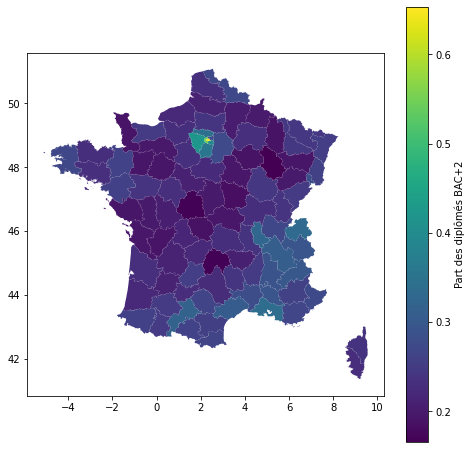

In [20]:
#Carte
dpt.merge(part_sup2, how='left').plot(column = 'T17_SUP2_P', 
                                      legend=True, legend_kwds={'label':'Part des diplômés BAC+2'},figsize=(8, 8))

Cette carte permet de visualiser les informations : lorsque les départements sont de couleurs claires, il s'agit plutôt des départements ayant la part de la population active contenant le plus de diplômés de l'enseignement supérieure, alors que les couleurs représentent à l'inverse, les départements où cette part est le moins élevée.


La carte suivante, créée grâce au package **plotly.express**, illustre exactement la même chose que la précédente, mais de manière **interactive** : lorsqu'on se déplace sur un département, on retrouve le nom et le numéro du département ainsi que la part de la population ayant au moins un BAC+2.


**POURQUOI CERTAINS DEPARTEMENTS N'APPARAISSENT PAS??**

In [21]:
#Min et max pour l'échelle de valeurs
#part_sup2['T17_SUP2_P'].min()
#part_sup2['T17_SUP2_P'].max()

fig = px.choropleth_mapbox(part_sup2, geojson=dpt.geometry, locations=part_sup2['DEP'],
                           color='T17_SUP2_P',
                           color_continuous_scale="Viridis",
                           range_color=(0.15, 0.65),
                           mapbox_style="carto-positron",
                           zoom=4, center = {"lat": 46,"lon": 2},
                           opacity=0.9,
                           labels={'T17_SUP2_P':'Part population avant au moins un BAC+2','DEP':'Département','nom':'Nom du département'})
fig.show()

### **1.4.4.** Répartition des diplômés du **BAC** dans la population active

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



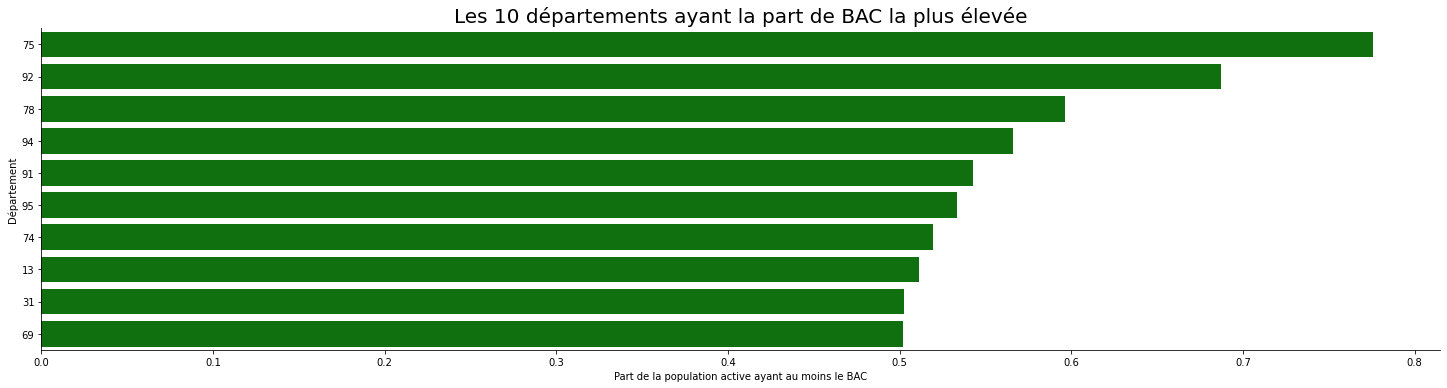

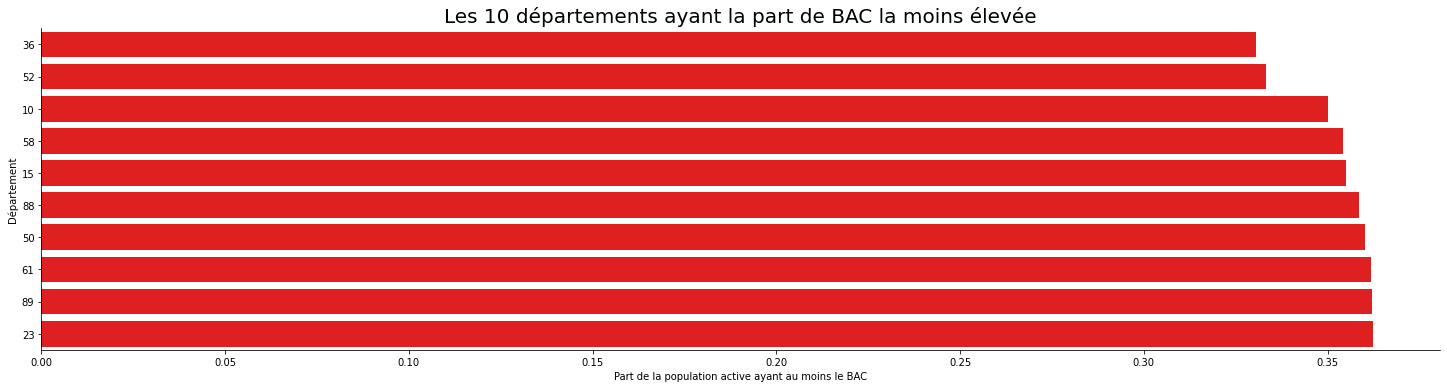

In [22]:
#T17_BAC nous donne seulement la part de la population ayant uniquement le BAC, mais nous pensons plus significatif d'étudier la population 
#ayant AU MOINS LE BAC.

part_bac = bdd_scolar_part[['T17_BAC','T17_SUP2','T17_SUP34','T17_SUP5','DEP']]
part_bac['T17_BAC_P']= part_bac['T17_BAC'] + part_bac['T17_SUP2'] + part_bac['T17_SUP34'] + part_bac['T17_SUP5']

#Barplot du top 10 : les 10 départements ayant la part de BAC la plus élevée
top_bac = part_bac.sort_values('T17_BAC_P',ascending=False).head(10)

graph_BAC = sns.catplot(x='T17_BAC_P', y='DEP', data=top_bac, kind = 'bar', height = 5, aspect = 4, color = "green")
graph_BAC.set_axis_labels('Part de la population active ayant au moins le BAC', 'Département')
plt.title('Les 10 départements ayant la part de BAC la plus élevée',size = 20)
plt.show()

#Barplot du bottom 10 : les 10 départements ayant la part de BAC la moins élevée
bottom_bac = part_bac.sort_values('T17_BAC_P',ascending=True).head(10)

graph_BAC = sns.catplot(x='T17_BAC_P', y='DEP', data=bottom_bac, kind = 'bar', height = 5, aspect = 4, color = "red")
graph_BAC.set_axis_labels('Part de la population active ayant au moins le BAC', 'Département')
plt.title('Les 10 départements ayant la part de BAC la moins élevée',size = 20)
plt.show()

Nous retrouvons les mêmes résultats qu'aux 2 parties différentes : en région parisienne, la proportion de la population active détenant au moins le BAC est la plus élevée. A l'opposé, cette proportion est faible en milieur rural.


### **1.4.5.** Répartition des diplômés du **BAC** dans la population active **à l'échelle de la commune**

Concentrons nous maintenant sur 2 départements que tout oppose : **Paris (75)** et le **Tarn-et-Garonne (82)**.
Le premier est le département le plus urbain de France, alors que le deuxième fait partie des plus ruraux.

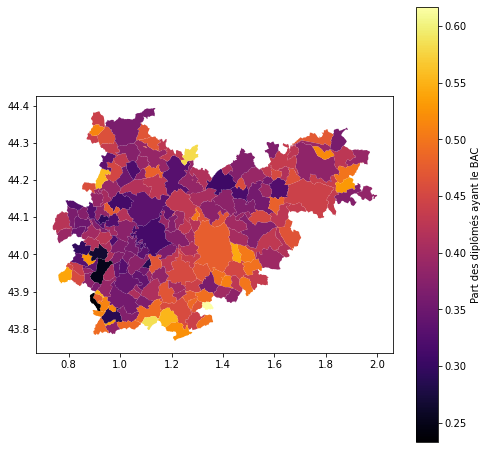

In [23]:
#Département 71 
bac82 = bdd_scolar[bdd_scolar.DEP=='82'].reset_index()
bac82 = bac82[['CODGEO','DEP','T17_BAC','T17_SUP2','T17_SUP34','T17_SUP5']]
bac82['T17_BAC_P']= bac82['T17_BAC'] + bac82['T17_SUP2'] + bac82['T17_SUP34'] + bac82['T17_SUP5']

fig82=communes2.merge(bac82, how='left').plot(column = 'T17_BAC_P', 
                                      legend=True, legend_kwds={'label':'Part des diplômés ayant le BAC'},
                                      figsize=(8, 8), cmap='inferno')

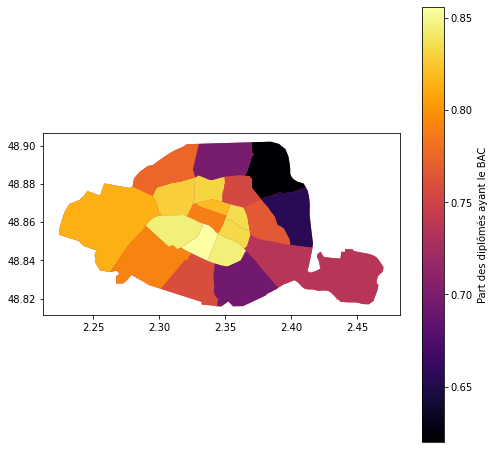

In [24]:
#Département 75
bac75 = bdd_scolar[bdd_scolar.DEP=='75'].reset_index()
bac75 = bac75[['CODGEO','DEP','T17_BAC','T17_SUP2','T17_SUP34','T17_SUP5']]
bac75['T17_BAC_P']= bac75['T17_BAC'] + bac75['T17_SUP2'] + bac75['T17_SUP34'] + bac75['T17_SUP5']

communes2.merge(bac75, how='left').plot(column = 'T17_BAC_P', 
                                      legend=True, legend_kwds={'label':'Part des diplômés ayant le BAC'},
                                      figsize=(8, 8), cmap='inferno')

A l'issu de ces deux cartes, on peut remarquer que **les taux les plus élevés dans le Tarn-et-Garonne correspondent aux taux les plus faibles dans la ville de Paris** (cf l'échelle des 2 graphiques). De plus, il ressort nettement une disparité des taux au sein de chaque département.

**Ainsi, les départements présentent en leur sein des parts de la population active ayant le BAC très différentes en fonction des communes**. 

De ce fait, nous allons effectuer notre étude de manière **plus fine**, c'est-à-dire à l'échelle de la commune, afin de pouvoir déterminer les facteurs précis.

## **1.5. Conclusion**


Les graphiques montrent de manière évidente que **la répartition des diplômés est inégalitaire en France**.
Les points principaux de cette première étude mettent en relief des proportions de diplômés du BAC, d'au moins un BAC+2 et de au moins un BAC+5 significativement supérieures dans la région parisienne, quand à l'inverse, ces proportions sont les plus faibles en milieu rural.

**Les parties suivantes vont alors permettre de détailler les facteurs pouvant avoir une conséquence sur l'éducation. 
Nous avons choisi d'étudier la part de réussite au BAC dans les lycées, à l'échelle communale.**

# **2. Importation des données et constitution de la dataframe**

## **2.1. Base comparateur des territoires - INSEE**

Pour notre étude, nous n'avons pas besoin de l'intégralité des variables présentes sur cette base, nous allons en sélectionner quelques unes : 

- Population en 2017 (**P17_POP**);
- Médiane du niveau vie en 2017 (**MED17**);
- Taux de pauvreté en 2O17 (**TP6017**);


Et en créer certaines :
- Taux de chômage en 2017 (**T17_CHOM1564**);
Le taux de chômage et le taux d'activité sont redondants, on ne décide de retenir que le taux de chômage de la liste des covariables que l'on souhaite utiliser dans notre modèle. 

In [25]:
bdd_ind_eco = csv_zip_to_df("https://www.insee.fr/fr/statistiques/fichier/2521169/base-comparateur-2017_CSV.zip","base_cc_comparateur.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.



In [26]:
#Création du taux de chômage et d'activité, et de la densité
taux('T17_ACT1564','P17_ACT1564','P17_POP1564',bdd_ind_eco)
taux('T17_CHOM1564','P17_CHOM1564','P17_POP1564',bdd_ind_eco)
taux('DEN17','P17_POP','SUPERF',bdd_ind_eco)

#Sélection de variables et arrondis
bdd_ind_eco = bdd_ind_eco[['CODGEO','P17_POP','DEN17','MED17','T17_CHOM1564', 'TP6017']]
bdd_ind_eco['CODGEO']= bdd_ind_eco['CODGEO'].astype(str).str.zfill(5)

bdd_ind_eco[['T17_CHOM1564']] = bdd_ind_eco[['T17_CHOM1564' ]].round(decimals=3)
bdd_ind_eco[['TP6017']] = bdd_ind_eco[['TP6017']] / 100

bdd_ind_eco.head(5)

CODGEO  P17_POP    DEN17    MED17  T17_CHOM1564  TP6017
0  01001      776   48.652  23310.0         0.071     NaN
1  01002      248   27.104  24290.0         0.069     NaN
2  01004    14035  570.528  19860.0         0.113    0.17
3  01005     1689  106.093  23370.0         0.063     NaN
4  01006      111   18.878  23970.0         0.111     NaN

## **2.2. Base scolarisation - INSEE**

Cette base de données étant déjà importée dans la partie **1.2. Importation des données en lien avec l'éducation**, on effectue seulement une sélection de variables afin de ne garder que :

*   La part de la population active ayant au moins le BAC (**Taux_sup**).

En effet, la part de la population active peut être un facteur concernant la réussite au BAC.




In [27]:
#Sélection de variables
bdd_scolar["Taux_sup"] = bdd_scolar["T17_BAC"] + bdd_scolar["T17_SUP2"] + bdd_scolar["T17_SUP34"] + bdd_scolar["T17_SUP5"]
bdd_scolar_bac = bdd_scolar[["CODGEO", 'Taux_sup','DEP']]

bdd_scolar_bac.head(5)

CODGEO  Taux_sup DEP
0  01001     0.426  01
1  01002     0.565  01
2  01004     0.449  01
3  01005     0.416  01
4  01006     0.454  01

## **2.3. Base établissements d'enseignement du premier et second degrés - DATA.EDUCATION.GOUV**

Cette base de données, issue de **Data.Education.Gouv**, nous permet d'avoir des **indicateurs concernant les lycées de France**. Nous allons garder les variables suivants : 


*   Taux de réussite au BAC général (séries S, L et ES) (**Taux_reussite_S,Taux_reussite_L, Taux_reussite_ES**);
*   Taux de mention au BAC (séries S, L et ES) (**Taux_mention_S, Taux_mention_L, Taux_mention_ES**);
*   Taux d'élèves présents dans les fillières générales (**Taux_gen**);
*   Secteur public ou privé (**Secteur_public**).



In [28]:
url = "https://data.education.gouv.fr/explore/dataset/fr-en-indicateurs-de-resultat-des-lycees-denseignement-general-et-technologique/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B"
bdd_results = pd.read_csv(url, sep =";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (52,53,56,57,58,59,75,76,78,79,80,81,93,95,98,100) have mixed types.Specify dtype option on import or set low_memory=False.



In [29]:
#On renomme quelques variables :
bdd_results = bdd_results.rename(columns = {'Code commune' : 'CODGEO',
                                            'Secteur Public/Prive':'Secteur_public',
                                            'Effectif Présents série S' :'Effectifs_S',
                                            'Effectif Présents série L':'Effectifs_L',
                                            'Effectif Présents série ES':'Effectifs_ES',
                                            'Effectif Présents Total séries':'Effectif_tot',
                                            'Taux Brut de Réussite série S' : 'Taux_reussite_S',
                                            'Taux Brut de Réussite série L':'Taux_reussite_L',
                                            'Taux Brut de Réussite série ES':'Taux_reussite_ES',
                                            'Taux_Mention_brut_serie_S':'Taux_mention_S',
                                            'Taux_Mention_brut_serie_L':'Taux_mention_L',
                                            'Taux_Mention_brut_serie_ES':'Taux_mention_ES'})

In [30]:
#Recodage de variables

## Taux d'élèves présents dans les fillières générales
bdd_results["Taux_gen"] = (bdd_results["Effectifs_S"] + bdd_results["Effectifs_L"] + bdd_results["Effectifs_ES"])/ bdd_results['Effectif_tot']

## On recode cette variable en une autre variable binaire pour savoir s'il s'agit d'un lycée général ou non :
bdd_results['Lycee_gen'] = bdd_results['Taux_gen'].apply(lambda x: 1 if x == 1.00 else 0)

## On ne garde que les valeurs de 2017
bdd_results = bdd_results[bdd_results.Année == 2017]

## On recode cette variable en variable binaire
bdd_results['Secteur_public'] = bdd_results['Secteur_public'].apply(lambda x: 1 if x == "PU" else 0)

bdd_results['CODGEO']= bdd_results['CODGEO'].astype(str).str.zfill(5)
bdd_results['DEP']= bdd_results['CODGEO'].str[:2]
bdd_results = bdd_results[bdd_results.DEP !='97']

#Sélection de variables 
bdd_results = bdd_results[['CODGEO','DEP', 'Secteur_public', 'Académie', 'Lycee_gen',
       'Taux_reussite_L', 'Taux_reussite_ES', 'Taux_reussite_S',
       'Taux_mention_L', 'Taux_mention_ES', 'Taux_mention_S']]

In [31]:
#Suppression des valeurs aberrantes : (département et CODGEO = 0)
print(pd.unique(bdd_results["DEP"]))
print(bdd_results[bdd_results["CODGEO"] == '0'])

bdd_results = bdd_results.drop(bdd_results[ bdd_results['CODGEO'] == '0' ].index)

['04' '13' '05' '84' '02' '60' '80' '25' '39' '90' '24' '33' '40' '64'
 '14' '50' '61' '03' '15' '43' '63' '2A' '2B' '77' '93' '94' '21' '58'
 '71' '89' '07' '26' '74' '38' '73' '59' '62' '19' '23' '01' '42' '69'
 '11' '30' '34' '48' '66' '54' '55' '57' '88' '44' '49' '53' '72' '85'
 '06' '83' '18' '28' '36' '37' '41' '45' '75' '16' '17' '79' '86' '08'
 '10' '52' '51' '22' '29' '35' '56' '27' '76' '67' '68' '12' '32' '31'
 '65' '46' '81' '82' '91' '92' '95' '78' '70' '47' '87' '09']
Empty DataFrame
Columns: [CODGEO, DEP, Secteur_public, Académie, Lycee_gen, Taux_reussite_L, Taux_reussite_ES, Taux_reussite_S, Taux_mention_L, Taux_mention_ES, Taux_mention_S]
Index: []


Notre variable d'intérêt est le **taux de réussite au bac général**, on supprime donc les lignes où ces données sont manquantes

In [32]:
bdd_results = bdd_results.dropna(subset=['Taux_reussite_L'])
bdd_results  = bdd_results.dropna(subset=['Taux_reussite_S'])
bdd_results  = bdd_results.dropna(subset=['Taux_reussite_ES'])

bdd_results.head(5)

CODGEO DEP  ...  Taux_mention_ES Taux_mention_S
2381  13001  13  ...             87.0           90.0
2382  13001  13  ...             25.0           74.0
2388  13206  13  ...             66.0           85.0
2389  13208  13  ...             47.0           44.0
2390  13209  13  ...             60.0           44.0

[5 rows x 11 columns]

## **2.4. Base retard en sixième - INSEE**

Cette base de données de l'INSEE nous permet d'avoir un **indicateur sur l'éducation et le niveau dans les collèges, à l'échelle des académies françaises**. La base recense des informations pour chacune des 29 académies françaises.Les indicateurs retenus sont :

*   Le taux de retard en sixième (**Taux_retard_sixième**);
*   La part des milieux favorisés parmi les élèves du secondaire (**part_fav**).


In [33]:
bdd_retard= pd.read_excel('https://www.insee.fr/fr/statistiques/fichier/1281332/ip1512.xls', sheet_name= "Figure 2a")
bdd_retard = bdd_retard.iloc[3:32]
bdd_retard.columns = ['Académie','part_fav', 'taux_retard_sixième']

print(bdd_retard["Académie"])

bdd_retard.head(5)

3            Amiens
4              Nice
5             Reims
6     Aix-Marseille
7              Caen
8             Dijon
9          Besançon
10            Rouen
11            Corse
12         Toulouse
13         Bordeaux
14      Montpellier
15           Rennes
16         Grenoble
17           Nantes
18    Orléans-Tours
19       Nancy-Metz
20            Lille
21         Clermont
22       Strasbourg
23             Lyon
24            Paris
25          Créteil
26       Versailles
27         Poitiers
28          Limoges
29       Guadeloupe
30       Martinique
31           Guyane
Name: Académie, dtype: object


Académie part_fav taux_retard_sixième
3         Amiens     16.6                14.1
4           Nice     22.2                12.1
5          Reims     14.8                13.5
6  Aix-Marseille     21.7                  13
7           Caen     16.2                13.8

## **2.5. Base géographie du cinéma : équipement et fréquentation - DATA.GOUV**

Cette base de données permet d'avoir un **indicateur culturel** à l'échelle de la commune :

* le nombre de cinéma par commune (**Nb_cinema_com**).

In [34]:
#Importation de la base 
bdd_cinema = pd.read_excel('https://www.data.gouv.fr/fr/datasets/r/cdb918e7-7f1a-44fc-bf6f-c59d1614ed6d', sheet_name ='2017')
bdd_cinema = bdd_cinema.iloc[4:]

print(bdd_cinema.columns)
bdd_cinema = bdd_cinema.rename(columns = {'Unnamed: 1' : "nom", 'Unnamed: 4' : 'CODGEO'})

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')


In [35]:
bdd_cinema['CODGEO']= bdd_cinema['CODGEO'].astype(str).str.zfill(5)
liste_cinema = bdd_cinema.groupby(['CODGEO'])['nom'].count()

In [36]:
#On transforme cette liste en data frame
bdd_cinema = pd.DataFrame(liste_cinema)
bdd_cinema = bdd_cinema.rename(columns = {'nom' : 'nb_cinema_com'})

bdd_cinema.head(5)

nb_cinema_com
CODGEO               
01004               1
01033               1
01034               1
01053               2
01093               1

## **2.6. Base des valeurs foncières - INSEE**

Le niveau de vie des habitants de chaque commune est capturé par les variables de la base comparateur des territoires, telles que la médiane du niveau de vie (**MED17**).Cependant, il nous a semblé pertinent d'inclure également un indice des prix des valeurs foncières de chaque commune, notamment dans les communes qui accueillent de nombreuses résidences secondaires, et où le prix du foncier est décorrélé du niveau de vie des habitants.

In [37]:
bdd_foncier = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/58b6b75e-4f15-4efb-adb5-3f7b939fb2d1', sep = ",")
bdd_foncier = bdd_foncier[["INSEE_COM", 'Prixm2']]

In [38]:
print(bdd_foncier["Prixm2"].isna().sum()/ len(bdd_foncier))
#La variable Prixm2 contient 19% de NA
bdd_foncier = bdd_foncier.rename(columns = {'INSEE_COM': 'CODGEO'})

bdd_foncier['CODGEO']= bdd_foncier['CODGEO'].astype(str).str.zfill(5)
bdd_foncier = bdd_foncier.sort_values('CODGEO',ascending=True)

bdd_foncier.head(5)

0.19542607759231445


CODGEO  Prixm2
8354   01001  1595.0
29208  01002  1239.0
23728  01004  1843.0
16203  01005  1798.0
20590  01006  2266.0

## **2.7. Consolidation des dataframes retenus**

A ce stage, nous avons des bases de données à l'échelle communale (**bdd_ind_eco, bdd_results, bdd_scolar, bdd_cinema, bdd_foncier**), et à l'échelle de l'académie (**bdd_retard**).



Il va alors s'agir de les fusionner, en gardant les **informations à l'échelle communale**. 

In [39]:
df = pd.merge(bdd_ind_eco, bdd_results, on = 'CODGEO', how = "right")

In [40]:
df2 = pd.merge(df, bdd_scolar_bac, on = 'CODGEO', how = "left")

In [41]:
del df2['DEP_x']
df2 = df2.rename(columns = {'DEP_y' : 'DEP'})

In [42]:
df3 = pd.merge(df2, bdd_foncier, on = 'CODGEO', how = "left")

In [43]:
df4 = pd.merge(df3, bdd_cinema, on = 'CODGEO', how = "left")
df4['nb_cinema_com'].fillna(0, inplace=True)

Pour terminer la constitution de la base de données, on va faire la consolidation de df5, qui contient toutes les données consolidées jusqu'alors, et bdd_retard. Pour ce faire, il faut que les deux base de données présentent des libellés de la colonne 'Académie' écrits de la même manière. 

In [44]:
bdd_retard = bdd_retard.sort_values(by ='Académie', ascending = True)
def up(x):
    return(x.upper())
bdd_retard["Académie"] = bdd_retard["Académie"].apply(up)
bdd_retard['Académie'] = bdd_retard['Académie'].str.replace('Ç', "C")
bdd_retard['Académie'] = bdd_retard['Académie'].str.replace('É', "E")
bdd_retard['Académie'] = bdd_retard['Académie'].replace({'CLERMONT' : 'CLERMONT-FERRAND'})

print(pd.unique(bdd_retard["Académie"]))
print(pd.unique(df2["Académie"]))
print(pd.unique(bdd_retard['Académie'].isin(df2['Académie'])))

['AIX-MARSEILLE' 'AMIENS' 'BESANCON' 'BORDEAUX' 'CAEN' 'CLERMONT-FERRAND'
 'CORSE' 'CRETEIL' 'DIJON' 'GRENOBLE' 'GUADELOUPE' 'GUYANE' 'LILLE'
 'LIMOGES' 'LYON' 'MARTINIQUE' 'MONTPELLIER' 'NANCY-METZ' 'NANTES' 'NICE'
 'ORLEANS-TOURS' 'PARIS' 'POITIERS' 'REIMS' 'RENNES' 'ROUEN' 'STRASBOURG'
 'TOULOUSE' 'VERSAILLES']
['AIX-MARSEILLE' 'AMIENS' 'BESANCON' 'BORDEAUX' 'CAEN' 'CLERMONT-FERRAND'
 'CORSE' 'CRETEIL' 'DIJON' 'GRENOBLE' 'LILLE' 'LIMOGES' 'LYON'
 'MONTPELLIER' 'NANCY-METZ' 'NANTES' 'NICE' 'ORLEANS-TOURS' 'PARIS'
 'POITIERS' 'REIMS' 'RENNES' 'ROUEN' 'STRASBOURG' 'TOULOUSE' 'VERSAILLES']
[ True False]


In [45]:
df_final = pd.merge(df4, bdd_retard, on = 'Académie', how = "left")
print(df_final.columns)
df_final[["CODGEO", 'DEP', 'Académie', 'Prixm2', 'nb_cinema_com','part_fav']]

Index(['CODGEO', 'P17_POP', 'DEN17', 'MED17', 'T17_CHOM1564', 'TP6017',
       'Secteur_public', 'Académie', 'Lycee_gen', 'Taux_reussite_L',
       'Taux_reussite_ES', 'Taux_reussite_S', 'Taux_mention_L',
       'Taux_mention_ES', 'Taux_mention_S', 'Taux_sup', 'DEP', 'Prixm2',
       'nb_cinema_com', 'part_fav', 'taux_retard_sixième'],
      dtype='object')


CODGEO DEP       Académie  Prixm2  nb_cinema_com part_fav
0     13001  13  AIX-MARSEILLE  4031.0            4.0     21.7
1     13001  13  AIX-MARSEILLE  4031.0            4.0     21.7
2     13001  13  AIX-MARSEILLE  4031.0            4.0     21.7
3     13001  13  AIX-MARSEILLE  4031.0            4.0     21.7
4     13001  13  AIX-MARSEILLE  4031.0            4.0     21.7
...     ...  ..            ...     ...            ...      ...
1685  78005  78     VERSAILLES  3325.0            1.0     34.2
1686  78172  78     VERSAILLES  3385.0            2.0     34.2
1687  78158  78     VERSAILLES  4960.0            0.0     34.2
1688  78335  78     VERSAILLES  2207.0            0.0     34.2
1689  78498  78     VERSAILLES  3417.0            1.0     34.2

[1690 rows x 6 columns]

Nous avons repéré une valeur aberrante concernant **Taux_reussite_S** qui valait 0 : or, il est peu probable qu'un lycée n'ait aucune réussite.

In [46]:
df_final = df_final[df_final.Taux_reussite_S !=0]

In [47]:
df_final['part_fav']=df_final['part_fav'].astype(float)
df_final['taux_retard_sixième']=df_final['taux_retard_sixième'].astype(float)

#Mettons les variables à la même échelle : les taux sont redressés entre 0 et 1.
df_final['T17_CHOM1564']=df_final['T17_CHOM1564'] * 100
df_final['TP6017']=df_final['TP6017'] * 100
df_final['Taux_sup']=df_final['Taux_sup'] * 100

df_final = df_final.sort_values('CODGEO',ascending=True)
df_final = df_final.reindex(columns={'CODGEO', 'P17_POP', 'DEN17', 'MED17', 'T17_CHOM1564', 'TP6017',
       'Secteur_public', 'Académie', 'Lycee_gen', 'Taux_reussite_L',
       'Taux_reussite_ES', 'Taux_reussite_S', 'Taux_mention_L',
       'Taux_mention_ES', 'Taux_mention_S', 'Taux_sup', 'DEP', 'Prixm2',
       'nb_cinema_com', 'part_fav', 'taux_retard_sixième'})

df_final = df_final.dropna(subset=['DEP'])

df_final.head(5)

Taux_reussite_L  Taux_sup  ...  P17_POP  Taux_reussite_ES
850              86.0      44.9  ...  14035.0              83.0
1609             88.0      38.0  ...  16423.0              86.0
276             100.0      38.7  ...   9103.0             100.0
277              72.0      38.7  ...   9103.0              82.0
851              94.0      47.6  ...   3229.0              88.0

[5 rows x 21 columns]

Le dataframe précédent **df_final** est celui qu'on va utiliser pour effectuer nos statistiques descriptives et notre analyse de données, **à l'échelle communale**.

In [48]:
df_final.isna().sum()

Taux_reussite_L          0
Taux_sup                 0
MED17                    0
nb_cinema_com            0
Taux_reussite_S          0
Taux_mention_L           0
T17_CHOM1564             0
TP6017                  28
DEN17                    0
Taux_mention_S           0
part_fav                 0
Lycee_gen                0
DEP                      0
Taux_mention_ES          0
taux_retard_sixième      0
CODGEO                   0
Académie                 0
Prixm2                 186
Secteur_public           0
P17_POP                  0
Taux_reussite_ES         0
dtype: int64

In [49]:
df_final.dtypes

Taux_reussite_L        float64
Taux_sup               float64
MED17                  float64
nb_cinema_com          float64
Taux_reussite_S        float64
Taux_mention_L         float64
T17_CHOM1564           float64
TP6017                 float64
DEN17                  float64
Taux_mention_S         float64
part_fav               float64
Lycee_gen                int64
DEP                     object
Taux_mention_ES        float64
taux_retard_sixième    float64
CODGEO                  object
Académie                object
Prixm2                 float64
Secteur_public           int64
P17_POP                float64
Taux_reussite_ES       float64
dtype: object

In [50]:
df_final_dep = df_final[['P17_POP','MED17','T17_CHOM1564',
                         'Taux_reussite_L','Taux_reussite_S','Taux_reussite_ES',
                         'Taux_sup','Prixm2','part_fav','taux_retard_sixième',
                         'DEP','nb_cinema_com']].groupby("DEP").agg({'P17_POP':'sum','MED17':'mean',
                                                                     'T17_CHOM1564':'mean','Taux_reussite_L':'mean',
                                                                     'Taux_reussite_S':'mean','Taux_reussite_ES':'mean',
                                                                     'Taux_sup':'mean','part_fav':'mean',
                                                                     'part_fav' :'mean', 'taux_retard_sixième' : 'mean',
                                                                     'nb_cinema_com':'sum'}).reset_index().rename(columns = {'nb_cinema_com':'nb_cinema'})
                                                                                   
df_final_dep.head(5)

DEP   P17_POP         MED17  ...  part_fav  taux_retard_sixième  nb_cinema
0  01  223814.0  21506.923077  ...      25.8                 12.0       15.0
1  02  315843.0  17243.333333  ...      16.6                 14.1       13.0
2  03  105463.0  18650.000000  ...      18.2                 12.2        4.0
3  04   71184.0  19386.000000  ...      21.7                 13.0        6.0
4  05   99570.0  20342.500000  ...      21.7                 13.0        9.0

[5 rows x 11 columns]

Le dataframe précédent **df_final_dep** est celui qu'on va utiliser pour effectuer nos statistiques descriptives et notre analyse de données, **à l'échelle départementale**.

#**3. Statistiques descriptives**

Dans cette partie, nous allons effectuer des statistiques **aux échelles de la commune, du département et de l'académie** afin de décrire notre ensemble de données.

La première partie est basée sur la **visualisation des données**, puis nous ferons des **statistiques univariées et bivariées** et une **analyse des composantes principales**. Cette dernière méthode permet de transformer des variables corrélées, dans le but de réduire les variables et de savoir lesquelles sont les plus pertinentes.

## **3.1. Visualisation**

Dans un premier temps, nous voulions voir la répartition des **taux de réussite par département  selon les séries** (S, ES et L), pour voir si des départements sortaient du lot.

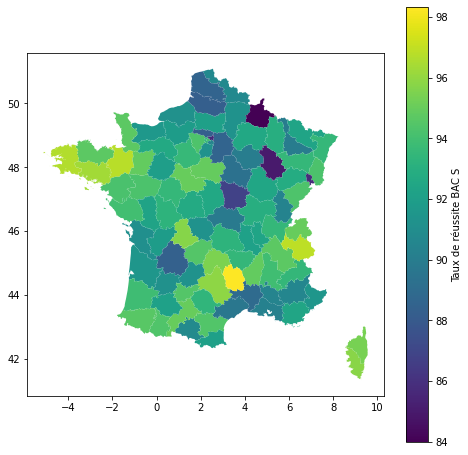

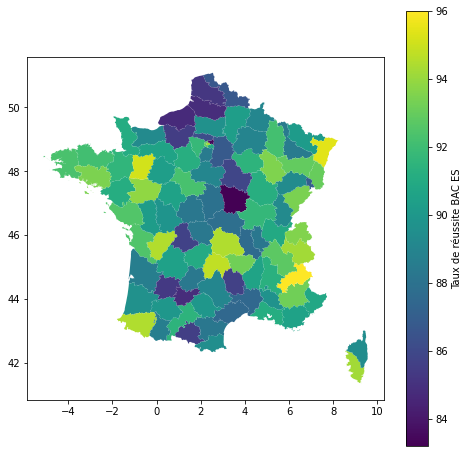

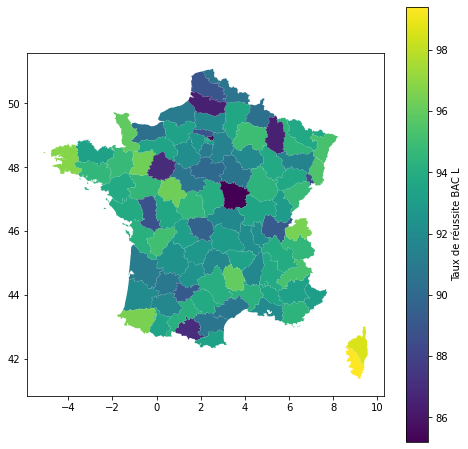

In [51]:
df_final_series = df_final[['Taux_reussite_S','Taux_reussite_ES','Taux_reussite_L','DEP']].groupby("DEP").agg({'Taux_reussite_S':'mean',
                                                                                                          'Taux_reussite_ES':'mean',
                                                                                                          'Taux_reussite_L':'mean'}).reset_index()
dpt.merge(df_final_series, how='left').plot(column = 'Taux_reussite_S', 
                                      legend=True, legend_kwds={'label':'Taux de réussite BAC S'},figsize=(8, 8))
dpt.merge(df_final_series, how='left').plot(column = 'Taux_reussite_ES', 
                                      legend=True, legend_kwds={'label':'Taux de réussite BAC ES'},figsize=(8, 8))
dpt.merge(df_final_series, how='left').plot(column = 'Taux_reussite_L', 
                                      legend=True, legend_kwds={'label':'Taux de réussite BAC L'},figsize=(8, 8))

Les cartes précédentes nous donnent les informations suivantes :
les meilleurs résultats de la **série S** se situent en Lozère (**48**) et en Bretagne, ceux de la **série ES** se situent à l'est de la France, et ceux de la **série L** en Corse.



Dans le but d'effectuer de la visualisation pour les **Taux_reussite_S, L et ES**, nous avons besoin d'avoir les données spatiales des lycées : **lycee_geo** contient les emplacements géographiques de chaque lycée en France métropolitaine. 

In [52]:
lycee_geo = gpd.read_file("https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/download/?format=geojson&timezone=Europe/Berlin&lang=fr")

lycee_geo=lycee_geo[['numero_uai','geometry','code_postal_uai']]

lycee_geo = lycee_geo.rename(columns = {'numero_uai' : 'CODE_ETAB','code_postal_uai':'CODGEO'})
lycee_geo = lycee_geo[lycee_geo.CODGEO.str[:2].apply(lambda x: x not in ('97'))]

Regardons maintenant la répartition des lycées dans les départements **75** et **82**.

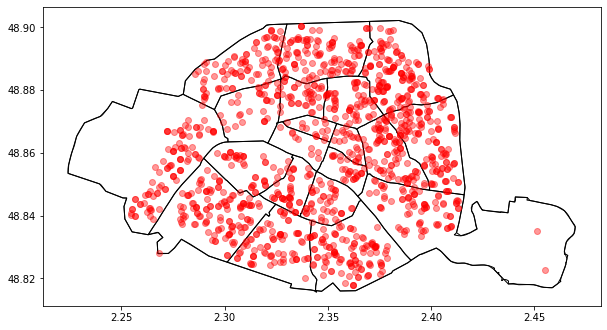

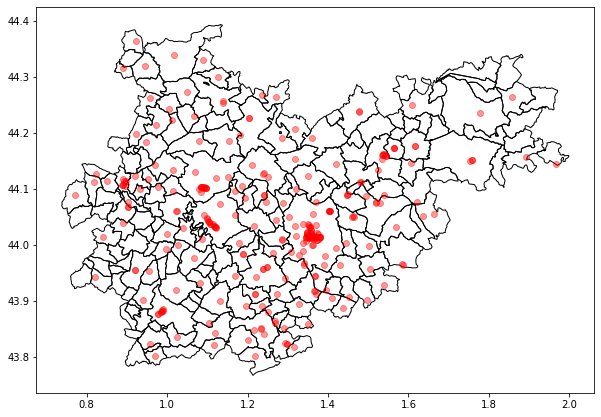

In [53]:
ax75 = lycee_geo[lycee_geo.CODGEO.str[:2]=="75"].plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes2[communes2.CODGEO.str[:2]=="75"].plot(ax = ax75, zorder=1, edgecolor = "black", facecolor="none")

ax82 = lycee_geo[lycee_geo.CODGEO.str[:2]=="82"].plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes2[communes2.CODGEO.str[:2]=="82"].plot(ax = ax82, zorder=1, edgecolor = "black", facecolor="none")

## **3.2 Statistiques univariées**

### **3.2.1.** Statistiques univariées des **variables d'intérêt : taux de réussite et mentions dans chaque série**

**Les boîtes à moustaches suivantes permettent de représenter graphiquement la distribution d'une variable quantitative**. Ici, il s'agit des taux de réussite, puis des taux de mentions dans les séries S, ES et L.

Elles résuments des indicateurs de position tels que la médiane, les quartiles à 25% et 75%, ainsi que le minimum et le maximum.
L

       Taux_reussite_ES  Taux_reussite_S  Taux_reussite_L
count       1687.000000      1687.000000      1687.000000
mean          90.095436        92.317724        92.577356
std            8.685340         7.245635         7.906544
min           35.000000        50.000000        43.000000
25%           86.000000        89.000000        88.000000
50%           92.000000        94.000000        94.000000
75%           97.000000        98.000000       100.000000
max          100.000000       100.000000       100.000000


Text(0.5, 1.0, 'Box plots du taux de réussite au bac')

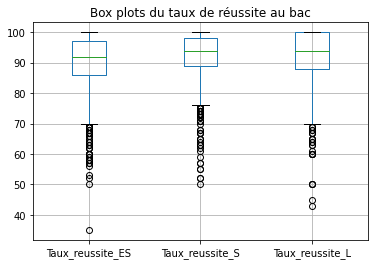

In [54]:
#Boîtes à moustaches des taux de réussite
print(df_final[['Taux_reussite_ES', 'Taux_reussite_S', 'Taux_reussite_L']].describe())

df_final[['Taux_reussite_ES', 'Taux_reussite_S', 'Taux_reussite_L']].boxplot()
plt.title('Box plots du taux de réussite au bac')

Les boîtes à moustaches précédentes montrent une distribution similaire. 

En effet, les valeurs médianes valent 92% pour la série ES et 94% pour les séries S et L. 
Le 3ème quartile de la série L est égale à la valeur maximale (100%), ce qui montre qu'au moins 1/4 des lycées ont une réussite certaine au BAC.

Nous pouvons également voir que des valeurs minimales se détachent du lot, mais il ne s'agit pas de valeurs totalement aberrantes.

       Taux_mention_ES  Taux_mention_S  Taux_mention_L
count      1687.000000     1687.000000     1687.000000
mean         47.532306       59.117961       52.060462
std          18.240908       17.316493       19.527907
min           0.000000        0.000000        0.000000
25%          35.000000       48.000000       39.000000
50%          46.000000       60.000000       50.000000
75%          59.000000       71.000000       64.000000
max         100.000000      100.000000      100.000000


Text(0.5, 1.0, 'Box plots du taux de mention au bac')

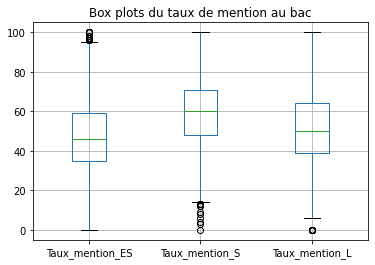

In [55]:
#Boîtes à moustaches des taux de mention
print(df_final[['Taux_mention_ES', 'Taux_mention_S', 'Taux_mention_L']].describe())

df_final[['Taux_mention_ES', 'Taux_mention_S', 'Taux_mention_L']].boxplot()
plt.title('Box plots du taux de mention au bac')

De la même manière, les boîtes à moustaches concernant les taux de mention suivent également une distribution similaire. 

Cependant, on remarque que la médiane et les quantiles sont plus élevés pour les étudiants en filière scientifique que pour les autres filières. Ce résultat peut etre expliqué par le fait que les étudiants qui obtiennent les meilleurs résultats au lycée sont incités à choisir une filière scientifique. Les données de ces colonnes étant mal renseignées dans les base INSEE considérées, ces résultats sont à considérer à titre indicatif.

Text(0.5, 1.0, 'Queue de distribition des taux de réussite au bac')

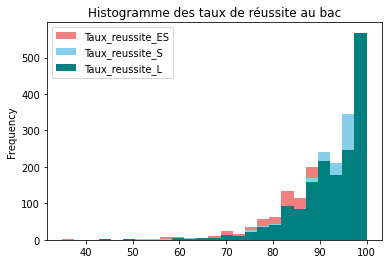

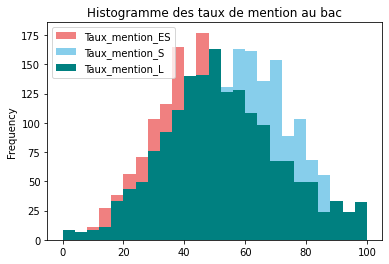

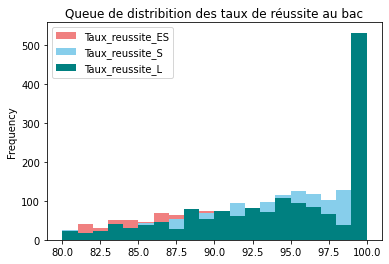

In [56]:
#Histogramme des taux de réussite au bac
df_final[['Taux_reussite_ES',"Taux_reussite_S", 'Taux_reussite_L']].plot.hist(bins= 25,color = ['lightcoral', 'skyblue','teal'])
plt.title('Histogramme des taux de réussite au bac')

#Histogramme des taux de mention au bac
df_final[["Taux_mention_ES", 'Taux_mention_S', 'Taux_mention_L']].plot.hist(bins= 25 ,color = ['lightcoral', 'skyblue','teal'])
plt.title('Histogramme des taux de mention au bac')

#Queue de distribition des taux de réussite au bac
df_final[['Taux_reussite_ES',"Taux_reussite_S", 'Taux_reussite_L']].plot.hist(bins= 20, range = [80,100], color = ['lightcoral', 'skyblue','teal'])
plt.title('Queue de distribition des taux de réussite au bac')

Les histogrammes en fréquence des taux de réussite au bac indiquent un **pic de fréquence à 100% de taux de réussite pour le bac L**. Ces résultats nous paraissent indiquer qu'il existe certains lycées dans lesquels la Terminale Littéraire est une classe d'excellence, où tous les élèves sont diplômés avec mention. 
On trouve un résultat similaire pour l'histogramme de la réussite au bac avec mention. 

### **3.2.2.** Statistiques univariées des **variables explicatives** 

count      1687.000000
mean      58201.008299
std       78553.892172
min         439.000000
25%       11527.000000
50%       28309.000000
75%       64551.000000
max      479553.000000
Name: P17_POP, dtype: float64


Text(0.5, 1.0, 'Histogramme en fréquence de la population des étudiées')

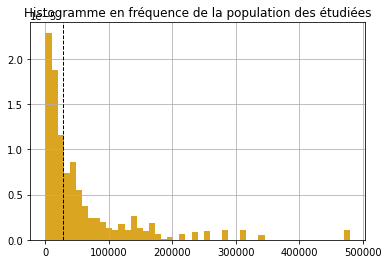

In [57]:
#Population par commune
print(df_final.P17_POP.describe())

df_final.P17_POP.hist(bins = 50, color="goldenrod", density= True)
plt.axvline(x = df_final.P17_POP.median() , color='k', linestyle='dashed', linewidth=1)
plt.title('Histogramme en fréquence de la population des étudiées')

Les statistiques descriptives effectuées sur la variable **P17_POP** nous montre que les lycées se situent dans des **villes de taille moyenne** : le premier quantile se trouve à 11527 habitants. 

count     1687.000000
mean     20931.120332
std       4487.859753
min      12170.000000
25%      18400.000000
50%      19780.000000
75%      21860.000000
max      44370.000000
Name: MED17, dtype: float64


Text(0.5, 1.0, 'Histogramme du niveau de vie médian par commune étudiée')

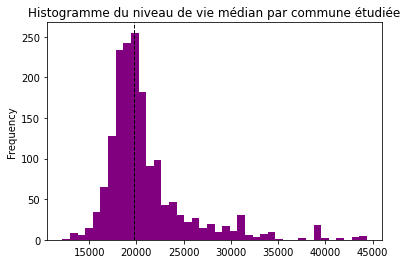

In [58]:
#Médiane du niveau de vie par commune
print(df_final.MED17.describe())

df_final.MED17.plot.hist( bins= 40, color='purple')
plt.axvline(x = df_final.MED17.median() , color='k', linestyle='dashed', linewidth=1)
plt.title("Histogramme du niveau de vie médian par commune étudiée")

L'histogramme en fréquence du niveau de vie médian est une courbe qui présente un **pic autour de sa valeur médiane et moyenne**. Il montre l'existence de certaines communes qui se détachent par un niveau de vie médian élevé ( > 30 000 euros). 

count    1659.000000
mean       18.089934
std         6.819578
min         5.000000
25%        13.000000
50%        18.000000
75%        22.000000
max        53.400000
Name: TP6017, dtype: float64
count    1687.000000
mean       11.531476
std         3.007947
min         4.600000
25%         9.300000
50%        11.600000
75%        13.400000
max        26.100000
Name: T17_CHOM1564, dtype: float64


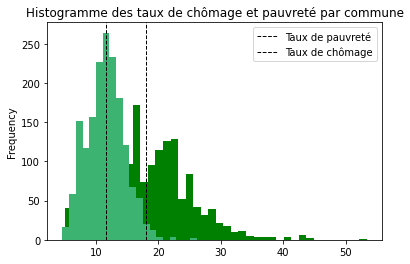

In [59]:
#Taux de pauvreté et taux de chômage par commune
print(df_final.TP6017.describe())
print(df_final.T17_CHOM1564.describe())

df_final.TP6017.plot.hist(bins= 40, color = 'green')
df_final.T17_CHOM1564.plot.hist(bins= 20, color="mediumseagreen")
plt.axvline(x = df_final.T17_CHOM1564.median() , color='k', linestyle='dashed', linewidth=1)
plt.axvline(x = df_final.TP6017.median() , color='k', linestyle='dashed', linewidth=1)

plt.title('Histogramme des taux de chômage et pauvreté par commune')
plt.legend(['Taux de pauvreté', 'Taux de chômage'])

Les histogrammes en fréquence des taux de pauvreté et de chômage suivent des profils similaires, avec des queues de distribution plus importantes à droite. On constate cependant que le taux de pauvreté présente une dispersion plus importante, avec la présence de communes où le taux de pauvreté est supérieur à 40%. 

0.6822762299940723


Text(0.5, 1.0, 'Histogramme des fréquences des lycées publics et privés')

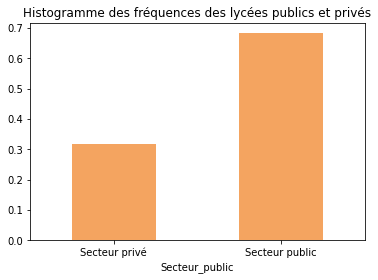

In [60]:
#Secteur public ou privé (variable binaire)
print(df_final.Secteur_public.sum()/len(df_final))

t = pd.crosstab(df_final.Secteur_public, "freq", normalize=True).plot(kind = "bar",color="sandybrown",legend=False)
t.xaxis.set_ticklabels(['Secteur privé', 'Secteur public'],rotation=0)
plt.title('Histogramme des fréquences des lycées publics et privés')

Les lycées publics représentent 68% des lycées français préparant au baccalauréat. 

0.7332542975696503


Text(0.5, 1.0, 'Histogramme des fréquences des lycées mixtes et généraux')

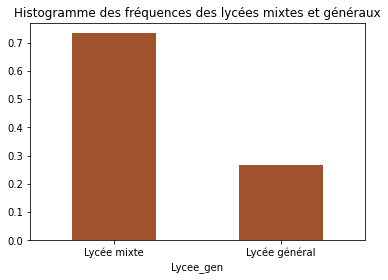

In [61]:
#Lycée général ou mixte (variable binaire)
print(1 - df_final.Lycee_gen.sum()/len(df_final))

t = pd.crosstab(df_final.Lycee_gen, "freq", normalize=True).plot(kind = "bar",color='sienna',legend=False)
t.xaxis.set_ticklabels(['Lycée mixte', 'Lycée général'],rotation=0)
plt.title('Histogramme des fréquences des lycées mixtes et généraux')

Les lycées qui ne préparent pas seulement au bac général sont majoritaires dans la base, puisqu'ils représentent plus de 73% des lycées. 


Text(0.5, 1.0, 'Répartition des lycées considérés par Académie')

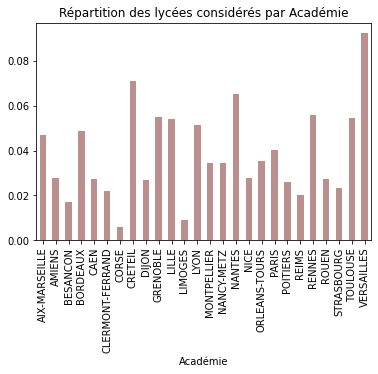

In [62]:
#Nombre de lycées par Académie
t = pd.crosstab(df_final.Académie, "freq", normalize=True)
t.plot(kind = "bar",color="rosybrown",legend=False)
plt.title("Répartition des lycées considérés par Académie")

On remarque que les académies les plus représentées dans la base sont celles de Versailles, de Créteil et de Nantes. 

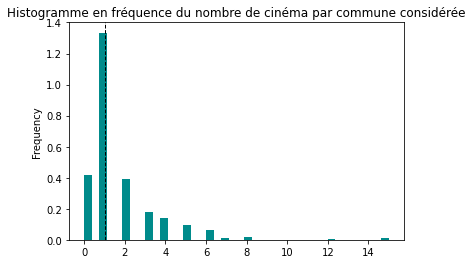

In [63]:
#Nombre de cinémas par commune
df_final.nb_cinema_com.plot.hist( bins= 40, density = True,color="darkcyan")
plt.title('Histogramme en fréquence du nombre de cinéma par commune considérée')
plt.axvline(x = df_final.nb_cinema_com.median() , color='k', linestyle='dashed', linewidth=1)

50 % des communes considérées compte un seul cinéma, et 75% en compte moins de deux. 

Text(0.5, 1.0, 'Histogramme en fréquence de la part de parents favorisés des élèves de 6ème')

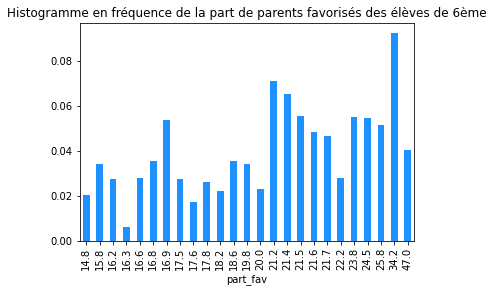

In [64]:
#Part des parents favorisés des élèves de 6ème
t = pd.crosstab(df_final.part_fav, "freq", normalize=True)
t.plot(kind = "bar", legend=False,color="dodgerblue")
plt.title('Histogramme en fréquence de la part de parents favorisés des élèves de 6ème')

Text(0.5, 1.0, 'Taux de retard en sixième ')

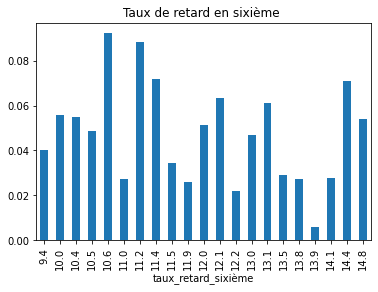

In [65]:
#Taux de retard en sixième 
u = pd.crosstab(df_final.taux_retard_sixième, "freq", normalize=True)
u.plot(kind = "bar",legend=False)
plt.title("Taux de retard en sixième ")

count    1501.000000
mean     2218.547635
std      1173.704998
min       812.000000
25%      1354.000000
50%      1861.000000
75%      2834.000000
max      8590.000000
Name: Prixm2, dtype: float64

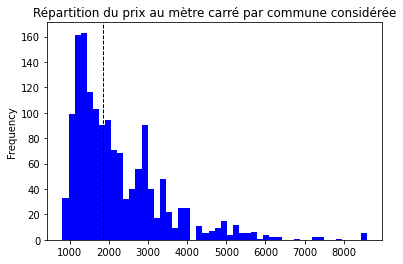

In [66]:
#Prix au M2 par commune
df_final.Prixm2.plot.hist(bins= 50,color='blue')
plt.axvline(x = df_final.Prixm2.median() , color='k', linestyle='dashed', linewidth=1)
plt.title('Répartition du prix au mètre carré par commune considérée')
df_final.Prixm2.describe()

Le prix au mètre carré par commune varie entre 812 et 8590 euros. Comme pour le niveau de vie médian et la population par commune, on remarque un pic pour les valeurs médianes, puis une queue de distribution sur la droite pour les communes au prix du mètre carré le plus élevé. 

##**3.3 Statistiques bivariées**

### **3.3.1.** Statistiques bivariées concernant les **variables d'intérêt**

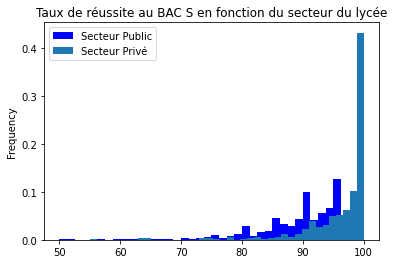

Text(0.5, 1.0, 'Taux de mention au BAC S en fonction du secteur du lycée')

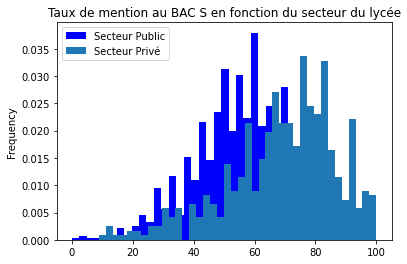

In [67]:
#Taux de réussite et taux de mention au BAC S en fonction du type de lycée (privé ou public)
df_final[df_final["Secteur_public"] == 1].Taux_reussite_S.plot.hist(bins= 40, color = 'blue', range = [50, 100], density = True )
df_final[df_final["Secteur_public"] == 0].Taux_reussite_S.plot.hist(bins= 40, density = True)
plt.legend(['Secteur Public', 'Secteur Privé'])
plt.title('Taux de réussite au BAC S en fonction du secteur du lycée')
plt.show()

df_final[df_final["Secteur_public"] == 1].Taux_mention_S.plot.hist(bins= 40, color = 'blue', density = True )
df_final[df_final["Secteur_public"] == 0].Taux_mention_S.plot.hist(bins= 40, density = True)
plt.legend(['Secteur Public', 'Secteur Privé'])
plt.title('Taux de mention au BAC S en fonction du secteur du lycée')

On constate grâce au histogrammes croisés que les lycées privés présentent un pic de fréquence autour de 100% de réussite au bac, alors que les lycées du public montrent des effectifs en fréquence plus dispersés pour la réussite au bac. 
Les lycées privés semblent également présenter un taux beaucoup plus important de mention au bac S, puisque leur effectif est centré autour de 80%, alors que l'effectif des lycées publics est centré autour de 60%. 

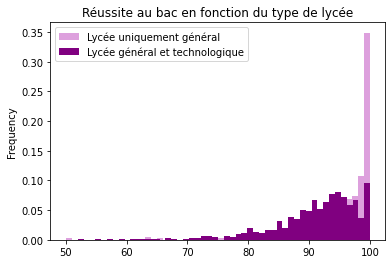

Text(0.5, 1.0, 'Réussite au bac en fonction du type de lycée')

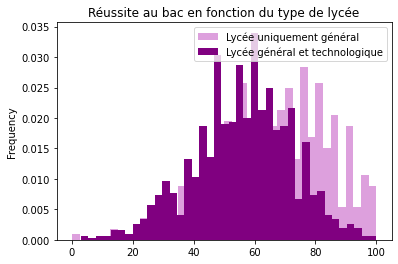

In [68]:
#Taux de réussite et taux de mention au BAC S en fonction du type de lycée (général ou mixte)
df_final[df_final["Lycee_gen"] == 1].Taux_reussite_S.plot.hist( bins= 50, color = 'plum', density = True )
df_final[df_final["Lycee_gen"] == 0].Taux_reussite_S.plot.hist( bins= 50, color= 'purple', density = True)
plt.legend(['Lycée uniquement général', 'Lycée général et technologique'])
plt.title('Réussite au bac en fonction du type de lycée')
plt.show()

df_final[df_final["Lycee_gen"] == 1].Taux_mention_S.plot.hist( bins= 40, color = 'plum', density = True)
df_final[df_final["Lycee_gen"] == 0].Taux_mention_S.plot.hist( bins= 40, color= 'purple', density = True)
plt.legend(['Lycée uniquement général', 'Lycée général et technologique'])
plt.title('Réussite au bac en fonction du type de lycée')


Les lycées qui préparent uniquement au bac général semblent présenter un taux de réussite au bac et de mention plus important que les lycées qui préparent également au baccalauréat dans des filières technologiques. 

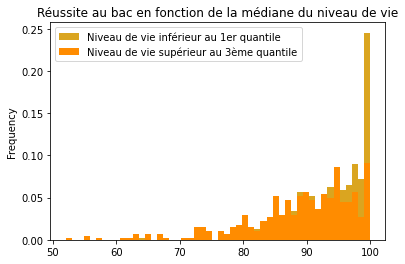

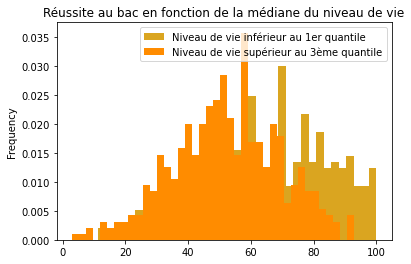

In [70]:
#Taux de réussite et taux de mention au BAC S en fonction des quartiles inférieurs et supérieurs 
#du niveau de vie
import numpy as np

#Quantile d'ordre 25% et 75%
quantile75_MED17 = np.quantile(df_final['MED17'].values,0.75)
quantile25_MED17 = np.quantile(df_final['MED17'].values,0.25)

df_final[df_final["MED17"] > quantile75_MED17].Taux_reussite_S.plot.hist( bins= 50, color = 'goldenrod', density = True)
df_final[df_final["MED17"] < quantile25_MED17].Taux_reussite_S.plot.hist( bins= 50, color = 'darkorange', density = True )
plt.legend(['Niveau de vie inférieur au 1er quantile', 'Niveau de vie supérieur au 3ème quantile'])
plt.title('Réussite au bac en fonction de la médiane du niveau de vie')
plt.show()

df_final[df_final["MED17"] > quantile75_MED17].Taux_mention_S.plot.hist( bins= 40, color= 'goldenrod', density = True)
df_final[df_final["MED17"] < quantile25_MED17].Taux_mention_S.plot.hist( bins= 40, color = 'darkorange', density = True)
plt.legend(['Niveau de vie inférieur au 1er quantile', 'Niveau de vie supérieur au 3ème quantile'])
plt.title('Réussite au bac en fonction de la médiane du niveau de vie')
plt.show()

En utilisant les valeurs des quantiles de la médiane du niveau de vie provenant de la partie d'ordre 25% et 75%, on compare les résultats au bac et les taux de mention des lycées se situant dans des communes relativement aisées, aux lycées se situant dans des communes relativement défavorisées. On observe que les lycées où la médiane du niveau de vie est plus élevé présentent des meilleurs résultats en proportion. 

### **3.3.2.** Statistiques bivariées par **académie**

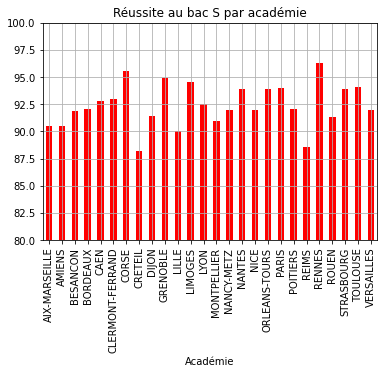

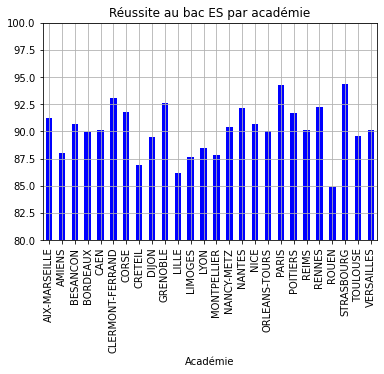

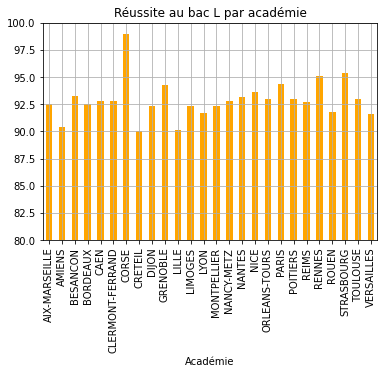

In [71]:
reussite_academ = df_final.groupby(['Académie'])['Taux_reussite_S'].mean()
reussite_academ.plot(kind='bar', color='red', grid = True)
plt.ylim((80, 100)) 
plt.title('Réussite au bac S par académie')
plt.show()

reussite_academ = df_final.groupby(['Académie'])['Taux_reussite_ES'].mean()
reussite_academ.plot(kind='bar', color='blue', grid = True)
plt.ylim((80, 100)) 
plt.title('Réussite au bac ES par académie')
plt.show()

reussite_academ = df_final.groupby(['Académie'])['Taux_reussite_L'].mean()
reussite_academ.plot(kind='bar', color='orange', grid = True)
plt.ylim((80, 100)) 
plt.title('Réussite au bac L par académie')
plt.show()

Les taux de réussite au bac par académie sont assez proches, et ne présentent pas de grosses disparités. De plus, les académies qui s'illustrent dans certaines filières (à l'image de la Corse pour le bac L), ne surperforment pas forcément dans d'autres.


On a remarqué dans la partie statistiques descriptives que les académies les plus représentées dans la base sont celles de Versailles, de Créteil et de Nantes. Le graphique suivant met en parallèle la densité par académie et le nombre de lycées étudiés par académie. 

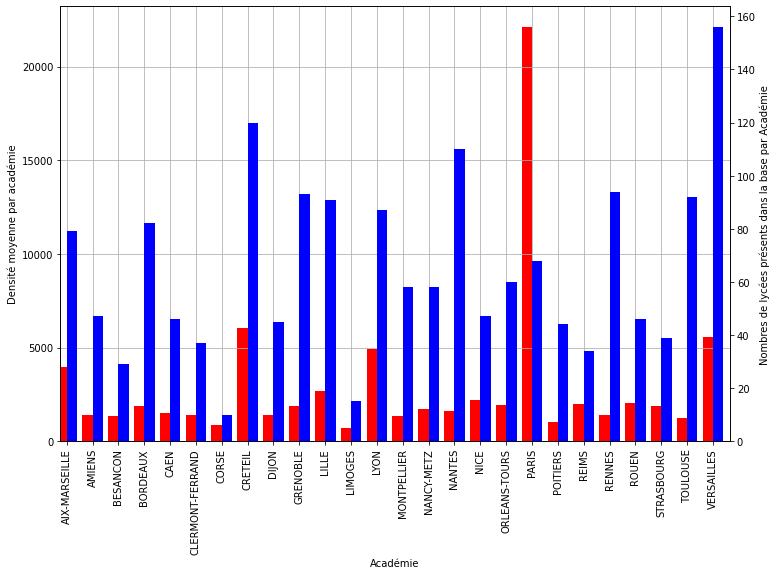

In [72]:
densite_academ = df_final.groupby(['Académie'])['DEN17'].mean()
nb_lycees_academ = df_final.groupby(['Académie'])['CODGEO'].count()

fig = plt.figure(figsize = [12, 8])

ax = fig.add_subplot(111) 
ax2 = ax.twinx() 

width = 0.4

densite_academ.plot(kind='bar', color='red', ax=ax, width=width, position=1, grid = True)
nb_lycees_academ.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Densité moyenne par académie')
ax2.set_ylabel('Nombres de lycées présents dans la base par Académie')

plt.show()

L'académie de Versailles et celle de Créteil sont sur-représentées dans la base au regard de leur densité. A contrario, l'académie de Paris est sous-représentée dans la base par rapport à sa densité. Il semble donc que la forte densité géographique de Paris augmente le nombre de lycées dans les académies de banlieue. Il est à noter qu'on considère ici le nombre de lycées par académie, sans prendre en compte la capacité d'accueil de chacun des lycées. 



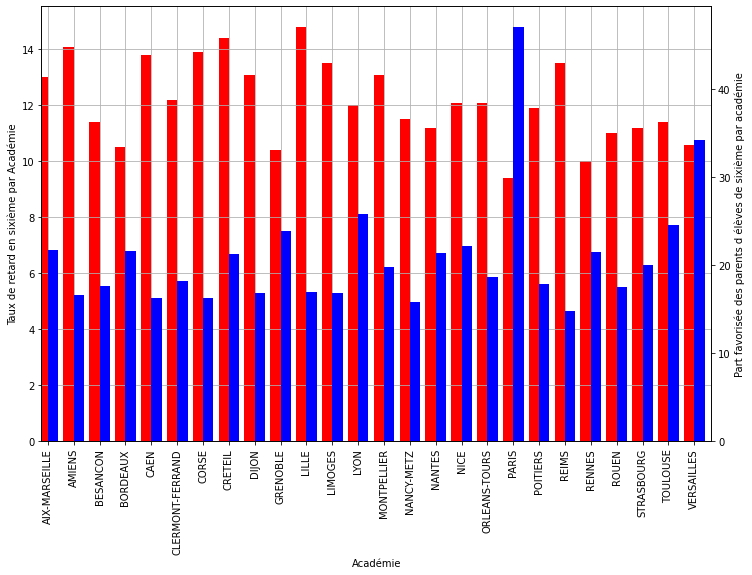

['AMIENS' 'CAEN' 'CORSE' 'LILLE' 'CRETEIL']


In [73]:
df_final["taux_retard_sixième"] = pd.to_numeric(df_final["taux_retard_sixième"])
df_final["part_fav"] = pd.to_numeric(df_final["part_fav"])

retard_academ = df_final.groupby(['Académie'])['taux_retard_sixième'].mean()
part_fav_academ = df_final.groupby(['Académie'])['part_fav'].mean()

fig = plt.figure(figsize = [12, 8])

ax = fig.add_subplot(111) 
ax2 = ax.twinx() 

width = 0.4
retard_academ.plot(kind='bar', color='red', ax=ax, width=width, position=1, grid = True)
part_fav_academ.plot(kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Taux de retard en sixième par Académie')
ax2.set_ylabel("Part favorisée des parents d élèves de sixième par académie")

plt.show()

print(pd.unique(df_final[df_final["taux_retard_sixième"] > 13.5]["Académie"]))

A la lecture de ce graphique, l'académie de Paris semble atypique, puisqu'elle présente une part favorisée des parents d'élèves de sixième relativement beaucoup plus importante que le reste des académies. L'académie de Versailles, dans une moindre mesure, présente elle aussi une part favorisée des parents d'élèves relativement importante (On observe au premier coup d'oeil que la barre bleue pour ces académies est très élevée, notamment au regard de la barre rouge). 
Les académies qui présentent le plus fort taux de retard en sixième sont les suivantes : AMIENS, CAEN, CORSE, LILLE, et CRETEIL. Il est intéressant de mettre ce résultat en parallèle avec le taux de réussite au bac (notamment littéraire), que présente l'Académie de la Corse dans les graphiques précédents. 

## 3.4 **Analyse en composantes principales**

On cherche à réaliser une analyse en composantes principales pour obtenir une représentation des départements en fonction de leurs caractéristiques. Pour se faire, on utilise le data frame df_final_dep, qui contient les données agrégées à l'échelle de chacun des départements. Pour réaliser cette analyse en composantes principales, on décide de se concentrer sur le taux de réussite au Bac scientifique.

In [110]:
from sklearn import decomposition
from sklearn import preprocessing


df_acp_dep = df_final_dep
df_acp_dep['DEP'] = df_acp_dep['DEP'].replace('2A', 200)
df_acp_dep['DEP'] = df_acp_dep['DEP'].replace('2B', 201)
#On a besoin de recoder les valeurs départementales de la Corse pour ne plus avoir de chaîne de caractères. 

df_acp_dep.index = df_acp_dep.DEP
#On veut indexer les valeurs de la base par le département, pour une lecture claire de l'ACP
df_acp_dep = df_acp_dep[['P17_POP', 'MED17', 'T17_CHOM1564',
       'Taux_reussite_S', 'Taux_sup', 'part_fav',
       'taux_retard_sixième', 'nb_cinema']]

df_acp_dep = df_acp_dep.fillna(df_acp_dep.mean())
#On remplace les valeurs manquantes par la moyenne, notamment pour la variable Prixm2 qui compte des NaN 

X = df_acp_dep.values
names = df_acp_dep.index 
features = df_acp_dep.columns
n_comp = 8
# Nombre de composante maximale



std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)


pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


p = len(df_acp_dep.columns)
n = len(df_acp_dep)
# Scree Test
bs = 1/numpy.arange(p,0,-1)
bs = numpy.cumsum(bs)
bs = bs[::-1]

eigval = (n-1)/n*pca.explained_variance_
print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))




   Val.Propre    Seuils
0    4.362683  2.717857
1    1.457122  1.717857
2    0.821661  1.217857
3    0.692477  0.884524
4    0.253824  0.634524
5    0.195603  0.434524
6    0.146567  0.267857
7    0.070062  0.125000


Sur le tableau ci-dessus (Scree Test), on remarque que seuls les deux premiers axes présentent des valeurs propres supérieures aux seuils considérés. 

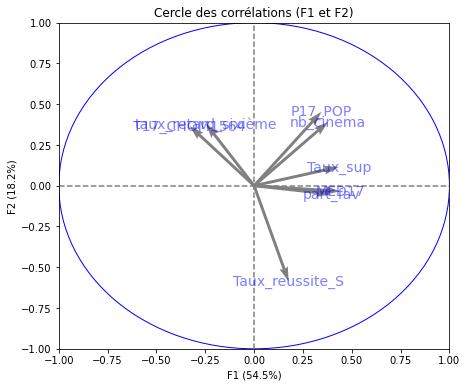

In [82]:
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = ['P17_POP', 'MED17', 'T17_CHOM1564',
       'Taux_reussite_S', 'Taux_sup', 'part_fav',
       'taux_retard_sixième', 'nb_cinema'])

#Ne marche pas sans les codes Open Classrooms

Pour les deux premiers axes factoriels, le taux de chômage et le taux de retard en sixième semblent très corrélés pour les départements retenus. La population par commune et le nombre de cinémas par commune sont également très corrélés : il semble que le nombre de cinéma soit une variable redondante de la population par commune, et ne permette pas de capturer le capital culturel dont dispose chaque lycéen. 


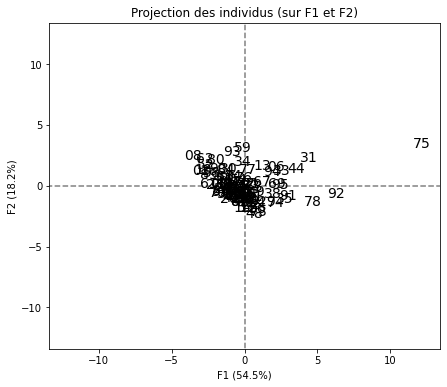

In [132]:
X_projected = pca.transform(X_scaled)
fig = display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = df_final_dep.index, alpha = 0)
# alpha  0 permet de ne pas afficher de points pour chaque département

On trouve ici que les départements 59, 93 et 80 sont ceux qui se distinguent le plus du reste de l'échantillon par leur taux de retard en sixième et leur taux de chômage élevé. Le 95, le 33 et le 06 se distinguent des autres départements par leur population élevée. Enfin, le 92, le 78 et surtout le 75 se distinguent de façon significative du reste du nuage des points par leur taux de personnes ayant fait des études supérieures (taux_sup) et leur médiane du niveau de vie. 

## **3.5. Corrélogramme des variables** 

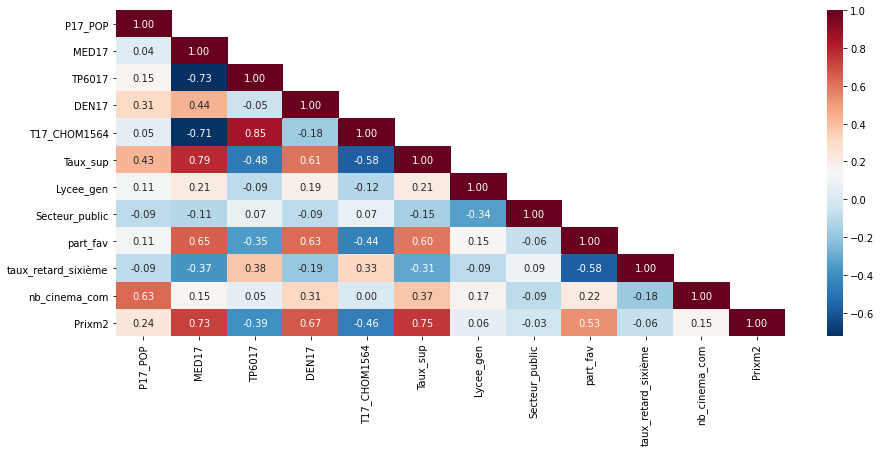

In [118]:
correlation_liste = df_final[['P17_POP','MED17','TP6017','DEN17','T17_CHOM1564','Taux_sup',
                              'Lycee_gen','Secteur_public','part_fav','taux_retard_sixième',
                              'nb_cinema_com','Prixm2']].corr()

#Pour avoir une matrice triangulaire inférieure
mask_ut=np.tril(np.ones(correlation_liste.shape)).astype(np.bool) 
correlation_liste2 = correlation_liste.where(mask_ut)

plt.subplots(figsize=(15, 6)) #Pour changer la taille
sns.heatmap(correlation_liste2, cmap="RdBu_r", annot=True, fmt='.2f')                             

Le corrélogramme précédent met en avant la forte corrélation entre la médiane du niveau de vie (**MED17**) et plusieurs autres variables : 
* le taux de pauvreté (**TP1760**) : corrélation = **-0,73**;
* le taux de chômage (**T17_CHOM1564**) : corrélation = **-0,71**;
* la part de diplômés dans la population active (**Taux_sup**) : corrélation = **0,79**;
* la part de parents favorisés des élèves de collège (**part_fav**) : corrélation = **0,65**;
* le prix des logements au m2 (**Prixm2**) : corrélation = **0,73**.

On remarque de plus que **T17_CHOM1564** et **TP6017** sont fortement corrélés (**0,85**), ainsi que **Prixm2** et **Taux_sup** (**0,75**).

Comme lorsqu'on effectue une régression linéaire, on pose l'hypothèse de la non-colinéarité entre les variables explicatives, on décide de ne pas inclure la médiane du niveau de vie (**MED17**), le taux de pauvreté (**TP6017**) et le prix au m2 (**Prixm2**).

Ainsi, nous poursuivons notre étude avec les variables suivantes :
* la population par commune (**P17_POP**);
* le taux de chômage par commune (**T17_CHOM1564**);
* la densité par commune (**DEN17**);
* la part de diplômés dans la population active par commune (**Taux_sup**);
* si un lycée est général ou mixte (technologie et général) (**Lycée_gen**);
* si un lycée est public ou privé (**Secteur_public**);
* la part de parents favorisés des élèves de collège (**part_fav**);
* le taux de retard en sixième (**taux_retard_sixième**);
* le nombre de cinéma par communes (**nb_cinema_com**).



# **4. Analyse de données**



Dans cette partie, nous allons effectuer des **modèles explicatifs**. D'abord, nous nous concentrerons le taux de réussite au BAC S, puis au taux de mention au BAC S.

En effet, au vu de nos statistiques descriptives et de la distribution des variables, nous pensons qu'il serait redondant d'effectuer des regressions pour les 3 séries.

## **4.1. Relation entre le taux de réussite au BAC S et le niveau d'éducation de l'entourage**

La variable **Taux_sup** correspond à la part de diplômés dans la population active : plus **Taux_sup** est élevé, plus la population active de la commune est diplômée. Ainsi, on peut considérer que cette variable permet d'identifier et de caractériser l'entourage d'un lycéen.

Ainsi, nous pensons que plus l'entourage d'un lycéen est diplômé plus celui-ci sera voué à faire des études, et donc par conséquent, voué à avoir le BAC. 
Nous allons alors **régresser Taux_reussite_S sur Taux_sup**: nous nous attendons à ce que les 2 variables soient positivement corrélées, c'est-à-dire,  à ce que le **coefficient de l'estimateur de Taux_sup soit positif**.

In [87]:
import statsmodels.api as sm

Y = df_final["Taux_reussite_S"]
X = df_final["Taux_sup"]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
ols_model = model.fit()
print(ols_model.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                            OLS Regression Results                            
Dep. Variable:        Taux_reussite_S   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     64.47
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           1.82e-15
Time:                        18:38:15   Log-Likelihood:                -5702.5
No. Observations:                1687   AIC:                         1.141e+04
Df Residuals:                    1685   BIC:                         1.142e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         87.2512      0.654    133.341      0.0

Comme attendu, le coefficient de *Taux_sup* est positif et **significatif à un niveau de 1%**. On peut alors l'interpréter de la manière suivante : **toute chose égale par ailleurs, si la part de diplômés dans la population active dans une ville augmente de 1 unité, alors le taux de réussite au BAC S augmentera de 0.104 unité.**

Cependant, ici le R² ajusté est très faible (**Adj. R-squared:0.036**), ce qui signifie que le modèle explique une très faible part la variance. Nous allons alors rajouter d'autres variables pour voir comment évolue R².

##**4.2. Relation entre le taux de réussite au BAC S et les variables retenues**

On régresse **Taux_reussite_S** sur **P17_POP**,**T17_CHOM1564** ,**DEN17** , **Taux_sup**, **P17_POP**, **Lycee_gen**, **Secteur_public**, **part_fav**, **taux_retard_sixième** et **nb_cinema_com**.

On peut alors s'attendre à une corrélation négative entre la variable d'intérêt **Taux_reussite_S** et **T17_CHOM1564**, **taux_retard_sixième** et **Secteur_public** (puisque les lycées privés ont généralement des meilleurs résultats que les lycées publics) et une relation positive avec les autres variables.

In [88]:
Y = df_final["Taux_reussite_S"]
X = df_final[["P17_POP","T17_CHOM1564","DEN17","Taux_sup","Lycee_gen","Secteur_public",
              "part_fav","taux_retard_sixième","nb_cinema_com"]]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
ols_model = model.fit(robust = 'hc3')
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:        Taux_reussite_S   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     61.27
Date:                Sat, 12 Dec 2020   Prob (F-statistic):           3.35e-97
Time:                        18:38:32   Log-Likelihood:                -5494.4
No. Observations:                1687   AIC:                         1.101e+04
Df Residuals:                    1677   BIC:                         1.106e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 106.5432    

Cette régression nous permet d'avoir une **variance expliquée plus grande** que la première (Adj. R-squared: 0.243).
De plus, toutes les variables sont significatives à 1%, sauf **nb_cinema_com** qui n'est pas significatif :

* Pour **T17_CHOM1564**  : lorsque la part de chômage augmente de 1 unité au sein d'une commune, le taux de réussite au BAC S **diminue de 0.213 unités**, toute chose égale par ailleurs.

* Pour **Taux_sup**  : lorsque la part de diplômés dans la population active augmente de 1 unité au sein d'une commune, le taux de réussite au BAC S **augmente de 0.129 unités**, toute chose égale par ailleurs.

* Pour **Lycee_gen** : si le lycée est uniquement général, alors le taux de réussite au BAC S **augmente de 1,408 unités**, toute chose égale par ailleurs.

* Pour **Secteur_public** : si le lycée est public, alors le taux de réussite au BAC S **diminue de 5.107 unités**, toute chose égale par ailleurs.

* Pour **part_fav** : lorsque la part de parents favorisés d'élèves de sixième augmente de 1 unité, le taux de réussite au BAC S **diminie de 0.149**, toute chose égale par ailleurs.

**Cependant, le signe de cette estimateur nous interpelle. En effet, nous pensions qu'il serait positif.**

* Pour **Taux_retard_sixième** : lorsque le taux de retard en sixième dans une commune augmente de 1 unité, alors le taux de réussite au BAC S dans la même commune **diminue de 0.879 unités**, toute chose égale par ailleurs.



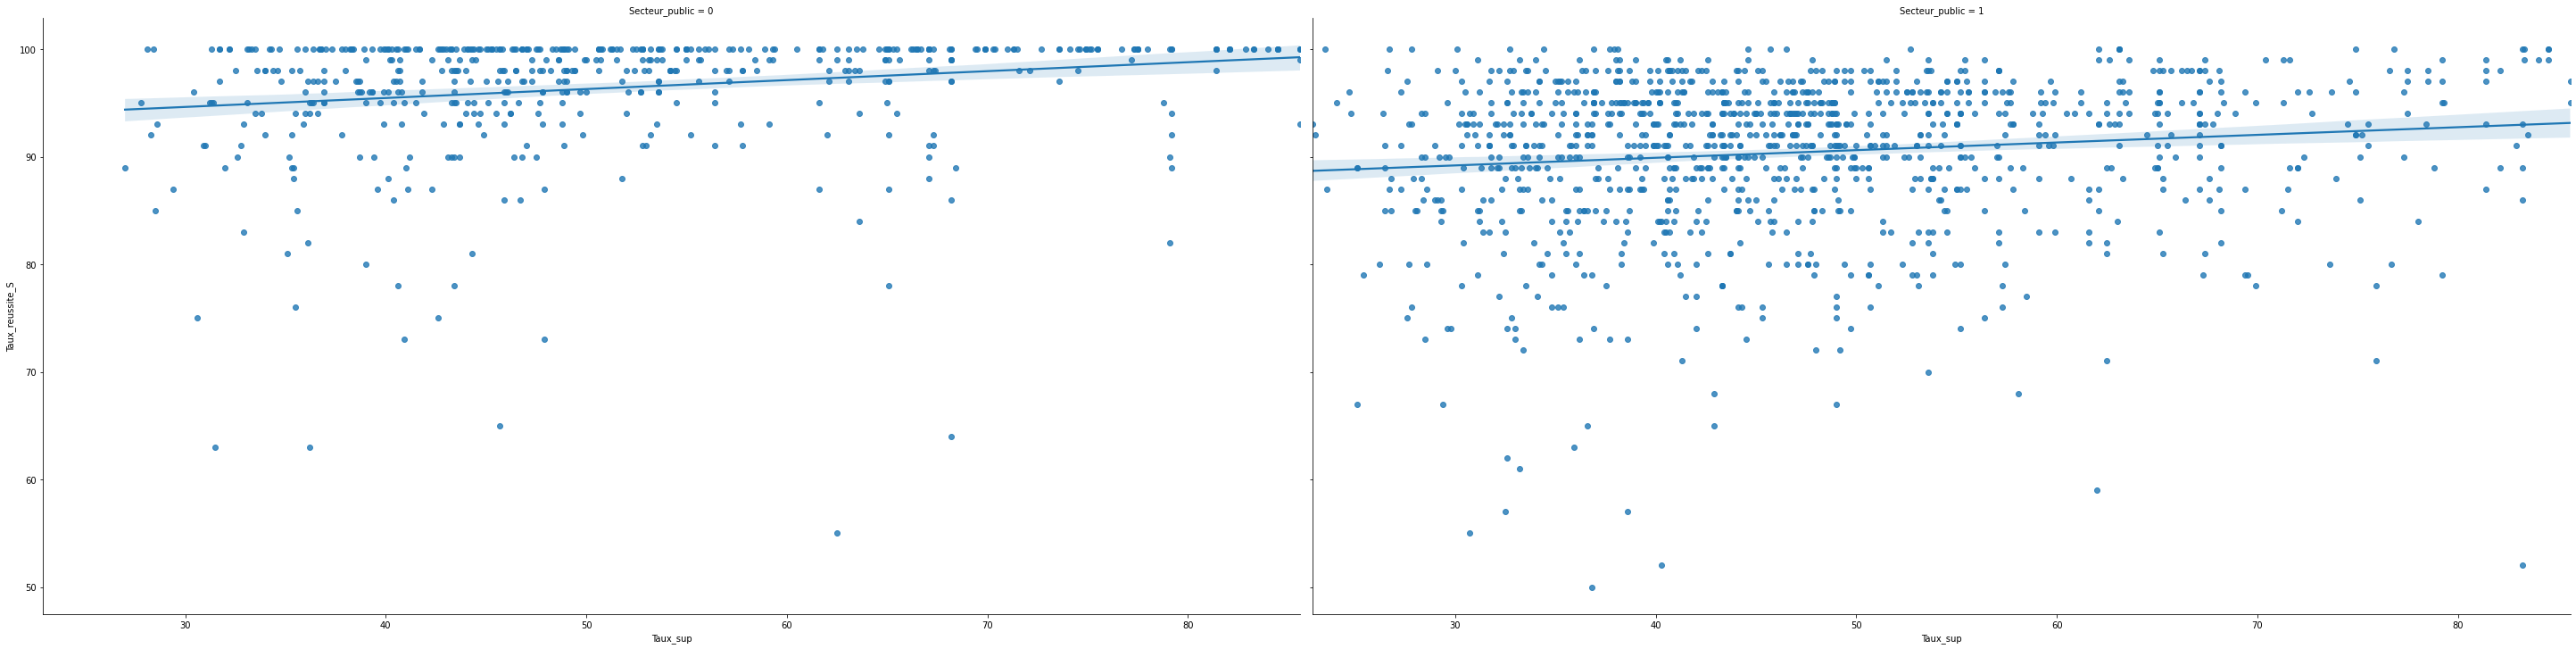

In [89]:
g = sns.lmplot(data=df_final, x="Taux_sup", col="Secteur_public", y="Taux_reussite_S",height=10, aspect=2)

La régression précédente du **Taux_reussite_S** sur **Taux_sup** en fonction du **Secteur (public ou privé)** nous indique que : toute chose égale par ailleurs, un lycée situé dans une ville avec une forte part de la population active diplômée (**Taux_sup**) est plus enclin à avoir un taux de réussite au BAC série S élevé, lorsqu'il s'agit d'un lycée privé. Sinon, la relation est moins flagrante.

## **4.3. Relation entre le taux de mention au BAC S et les variables retenues**

In [90]:
Y = df_final["Taux_mention_S"]
X = df_final[["P17_POP","T17_CHOM1564","DEN17","Taux_sup","Lycee_gen","Secteur_public",
              "part_fav","taux_retard_sixième","nb_cinema_com"]]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
ols_model = model.fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         Taux_mention_S   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     68.25
Date:                Sat, 12 Dec 2020   Prob (F-statistic):          3.40e-107
Time:                        18:39:01   Log-Likelihood:                -6940.8
No. Observations:                1687   AIC:                         1.390e+04
Df Residuals:                    1677   BIC:                         1.396e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  77.2292    

Le R² ajusté a augmenté (**Adj. R-squared: 0.268**), ce qui signifie que ce modèle permet d'expliquer une plus grande variance que le modèle précédent.

Cette régression permet d'avoir des estimateurs du même signe que la précédente. De plu,s **nb_cinema_com** est maintenant significatif à un niveau de 1%.

 # 5.**Analyse de données : prédiction**#

## 5.1 Prédiction par régression linéaire##

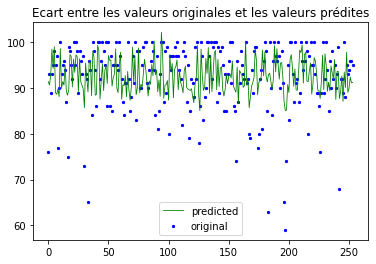

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

x_train, x_test, y_train, y_test=train_test_split(X, Y, random_state=12, 
             test_size=0.15)
ols = LinearRegression().fit(x_train, y_train)
y_pred = ols.predict(x_test)
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="green", label="predicted")
plt.legend()
plt.title('Ecart entre les valeurs originales et les valeurs prédites')
plt.show()
erreur_ols = mean_squared_error(y_test,y_pred)


## 5.2 Prédiction par régression Ridge##

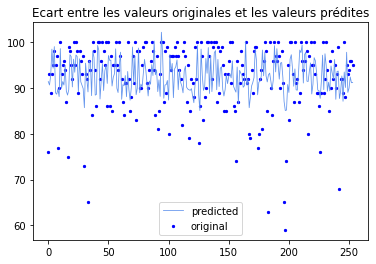

In [108]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV()
#RidgeCV détermine par validation croisée les meilleurs paramètres pour prédire les données. 

xtrain, xtest, ytrain, ytest=train_test_split(X, Y, random_state=12, 
             test_size=0.15)

ridge.fit(xtrain, ytrain)
ypred = ridge.predict(xtest)
erreur_ridge = mean_squared_error(ytest,ypred)

plt.scatter(x_ax, ytest, s=5, color="blue", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="cornflowerblue", label="predicted")
plt.legend()
plt.title('Ecart entre les valeurs originales et les valeurs prédites')
plt.show()

## 5.3 Prédiction par gradient boosting ##

On cherche désormais à prédire le taux de réussite au bac d'un lycée, en fonction des covariables étudiées. 

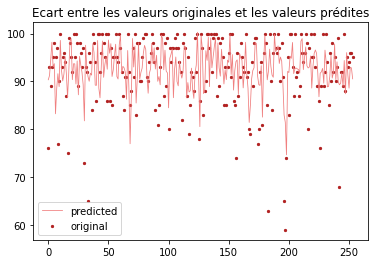

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xtrain, xtest, ytrain, ytest=train_test_split(X, Y, random_state=12, 
             test_size=0.15)

gbr = GradientBoostingRegressor(n_estimators=600, max_depth=5, learning_rate=0.01, min_samples_split=3)
gbr.fit(xtrain, ytrain)
ypred = gbr.predict(xtest)
erreur_grad = mean_squared_error(ytest,ypred)
x_ax = range(len(ytest))
plt.scatter(x_ax, ytest, s=5, color="firebrick", label="original")
plt.plot(x_ax, ypred, lw=0.8, color="lightcoral", label="predicted")
plt.legend()
plt.title('Ecart entre les valeurs originales et les valeurs prédites')
plt.show()


In [109]:
df_erreurs = pd.DataFrame({'erreurs' : ['OLS', 'Ridge', 'Gradient'], 'valeurs' : [erreur_ols, erreur_ridge, erreur_grad] })
df_erreurs

erreurs    valeurs
0       OLS  37.225063
1     Ridge  37.231957
2  Gradient  35.874300

On remarque que l'estimateur Ridge ne permet pas ici de réaliser un gain significatif en terme d'erreur de prédiction des moindres carrés, alors que le modèle gradient boosting, même sans optimiser le taux d'apprentissage, permet un gain signicatif en terme d'erreurs.  

#**Conclusion**